# Library design for CTP-04, 25kb Chr21 tracing 7x21


by Pu Zheng and Jun-Han Su

This library design is for human chr21 tracing at 25 kb resolution

In [9]:
#minimum imports:
import time,os,sys,glob
import cPickle as pickle
import numpy as np
import khmer
sys.path.append(r'/n/home13/pzheng/Documents/python-functions/python-functions-library')

from LibraryConstruction import fastaread,fastawrite,fastacombine
import LibraryDesigner as ld
import LibraryConstruction as lc

## 3 Assign region into TADs

In [13]:
def Match_TADs(report_folder, TAD_ref, save_folder, save=True, verbose=True):
    '''Function to match regions with a TAD reference
    Inputs: 
        report_folder: directory for extracted probe files, string
        TAD_ref: full filename for TAD reference, string
        save_folder: directory for saving results id->TAD, string
        save: whether save result, bool (default: True)
        verbose: wether say something! bool (default: True)
    Outputs:
        '''
    import os, glob, sys
    import LibraryDesigner as ld
    import numpy as np
    import cPickle as pickle
    
    def Read_TAD_ref(TAD_ref=TAD_ref):
        _tad_dics = [];
        with open(TAD_ref) as _ref_handle:
            _lines = _ref_handle.readlines();
            for _line in _lines:
                _chrom = _line.split(':')[0]
                _reg_str = _line.split(':')[1].split('\n')[0];
                _start,_stop = _reg_str.split('-');
                _tad_dic = {'chr':_chrom, 'start':int(_start), 'stop':int(_stop)}
                _tad_dics.append(_tad_dic);
        return sorted(_tad_dics, key=lambda d:d['start']);
    
    def Region_to_TAD(tad_dics, report_filename):
        _pb = ld.pb_reports_class()
        _pb.load_pbr(report_filename)
        # get its region status
        _reg_id = int(_pb.pb_reports_keep.values()[0]['reg_name'].split('reg')[1].split('_')[1])
        _chrom = _pb.pb_reports_keep.values()[0]['reg_name'].split(':')[0]
        _start, _stop = _pb.pb_reports_keep.values()[0]['reg_name'].split(':')[1].split('_')[0].split('-')
        _start = int(_start);
        _stop = int(_stop);
        if _start > _stop:
            _start, _stop = _stop, _start
        _reg_len = abs(_stop - _start)
        # initialize tad identity of this region
        _tad_id = -1;
        for i in range(len(tad_dics)):
            _dic = tad_dics[i];
            if _chrom == _dic['chr']:
                _overlap = min(_stop, _dic['stop']) - max(_start, _dic['start']);
                if _overlap > _reg_len / 2:
                    _tad_id = i; # assign tad id
                    break
    
        return _reg_id, _tad_id, len(_pb.pb_reports_keep)
    
    def Extra_Region_Assigning(tad_id_dic):
        '''Try to assign region to TADs as much as possible
        '''
        # calculate how many region has been assigned to each TAD
        _v,_c = np.unique(tad_id_dic.values(),return_counts=True)
        _reg_num_dic = dict(zip(_v,_c)) # dictionary for region number of each TAD

        # maximum gap size to be filled
        _gap_max = 4 

        # new_id_dic
        _new_id_dic = tad_id_dic.copy();

        # Starting filling gaps!
        _gap = 0;
        _prev_value = -1;
        for _key, _value in sorted(_new_id_dic.items()):
            # start a gap 
            if _gap == 0 and _value == -1: 
                _prev_tad = _prev_value
                _gap = 1; # turn on gap
                _key_ingap = [_key] # start recording keys in gap

            # continue a gap
            elif _gap == 1 and _value == -1:
                _key_ingap.append(_key)

            # stop a gap!
            elif _gap == 1 and _value > -1:
                _gap = 0; # stop counting gap
                _next_tad = _value 
                # if the gap is not huge, try to make up
                if len(_key_ingap) <= _gap_max: 
                    if _prev_tad == -1: # don't fill any gap at beginning
                        continue 
                    elif len(_key_ingap)/2*2 == len(_key_ingap): # gap size is even number
                        for i in range(len(_key_ingap)/2):
                            _new_id_dic[_key_ingap[i]] = _prev_tad
                            _new_id_dic[_key_ingap[i+len(_key_ingap)/2]] = _next_tad
                    else: # gap size is odd number
                        for i in range(len(_key_ingap)/2):
                            _new_id_dic[_key_ingap[i]] = _prev_tad
                            _new_id_dic[_key_ingap[i+len(_key_ingap)/2+1]] = _next_tad
                        if _reg_num_dic[_prev_tad] <= _reg_num_dic[_next_tad]:
                            _new_id_dic[_key_ingap[len(_key_ingap)/2]] = _prev_tad
                        else:
                            _new_id_dic[_key_ingap[len(_key_ingap)/2]] = _next_tad

            _prev_value = _value # store previous tad info

        return _new_id_dic   
    
    def Save_dics(save_folder, tad_dics, reg_len_dic, new_id_dic):
        # save tad dics
        tad_dic_file = open(save_folder+os.sep+'TAD_dic_list.pkl','w');
        pickle.dump(tad_dics, tad_dic_file);
        tad_dic_file.close()
        # save region length dic
        reg_len_dic_file = open(save_folder+os.sep+'region_length.pkl','w');
        pickle.dump(reg_len_dic, reg_len_dic_file);
        reg_len_dic_file.close()        
        # save region_to_tad dic
        reg_to_tad_file = open(save_folder+os.sep+'region_to_TAD.pkl','w');
        pickle.dump(new_id_dic, reg_to_tad_file);
        reg_to_tad_file.close() 

    if verbose:
        print '- Start reading TAD reference', TAD_ref
    tad_dics = Read_TAD_ref() # load tad info
    if verbose:
        print "-- Number of Tads in reference:", len(tad_dics)
    
    if verbose:
        print '- Start reading probe reports'
    files = glob.glob(report_folder + os.sep + '*.pbr') # extract all probe files
    tad_id_dic = {} # store assigned tad id
    reg_len_dic = {} # store number of probes in each region
    
    for _file in sorted(files, key=lambda fl:int(fl.split('.pbr')[0].split('_')[-1])):
        reg_id, tad_id, reg_len = Region_to_TAD(tad_dics, _file)
        tad_id_dic[reg_id] = tad_id; # update tad id dic
        reg_len_dic[reg_id] = reg_len; # update region length dic
        if verbose:
            print '--', os.path.basename(_file), 'tad_id:', tad_id, 'size:', reg_len
    
    # update tads by putting gaps
    new_id_dic = Extra_Region_Assigning(tad_id_dic)
    
    if save:
        Save_dics(save_folder=save_folder,
                 tad_dics=tad_dics,
                 reg_len_dic=reg_len_dic,
                 new_id_dic=new_id_dic);

    
    return tad_dics, tad_id_dic, reg_len_dic, new_id_dic
  

In [14]:
# get previous outputs
max_pb_num = 400;
min_pb_num = 150;

# probes from 9x36
probe_folder=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_9by36/reports/centered_merged400';

# this library is 7x21
library_folder = r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21';

tad_dics, tad_id_dic, reg_len_dic, new_id_dic= Match_TADs(probe_folder,
                                                          TAD_ref=library_folder+os.sep+'chr21_TADs.bed', 
                                                          save_folder=library_folder)

- Start reading TAD reference /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21/chr21_TADs.bed
-- Number of Tads in reference: 34
- Start reading probe reports
-- reg_201.pbr tad_id: -1 size: 189
-- reg_202.pbr tad_id: -1 size: 225
-- reg_203.pbr tad_id: -1 size: 223
-- reg_204.pbr tad_id: -1 size: 264
-- reg_205.pbr tad_id: -1 size: 288
-- reg_206.pbr tad_id: -1 size: 327
-- reg_207.pbr tad_id: -1 size: 159
-- reg_241.pbr tad_id: -1 size: 174
-- reg_242.pbr tad_id: -1 size: 260
-- reg_243.pbr tad_id: -1 size: 285
-- reg_244.pbr tad_id: -1 size: 300
-- reg_245.pbr tad_id: -1 size: 285
-- reg_246.pbr tad_id: -1 size: 258
-- reg_258.pbr tad_id: -1 size: 223
-- reg_259.pbr tad_id: -1 size: 290
-- reg_260.pbr tad_id: -1 size: 260
-- reg_262.pbr tad_id: -1 size: 218
-- reg_263.pbr tad_id: -1 size: 291
-- reg_311.pbr tad_id: -1 size: 226
-- reg_312.pbr tad_id: -1 size: 201
-- reg_313.pbr tad_id: -1 size: 163
-- reg_314.pbr tad_id: -1 size: 171
-- reg_390.pbr tad_id: -1 size:

-- reg_774.pbr tad_id: 3 size: 324
-- reg_775.pbr tad_id: 3 size: 304
-- reg_776.pbr tad_id: 3 size: 327
-- reg_777.pbr tad_id: 3 size: 282
-- reg_778.pbr tad_id: 3 size: 249
-- reg_779.pbr tad_id: 3 size: 328
-- reg_780.pbr tad_id: 3 size: 309
-- reg_781.pbr tad_id: 3 size: 311
-- reg_782.pbr tad_id: 3 size: 319
-- reg_783.pbr tad_id: 3 size: 349
-- reg_784.pbr tad_id: 3 size: 284
-- reg_785.pbr tad_id: 3 size: 327
-- reg_786.pbr tad_id: 3 size: 248
-- reg_787.pbr tad_id: 3 size: 271
-- reg_788.pbr tad_id: 3 size: 313
-- reg_789.pbr tad_id: 3 size: 316
-- reg_790.pbr tad_id: 3 size: 262
-- reg_791.pbr tad_id: 3 size: 291
-- reg_792.pbr tad_id: 3 size: 315
-- reg_793.pbr tad_id: 3 size: 287
-- reg_794.pbr tad_id: 3 size: 338
-- reg_795.pbr tad_id: 3 size: 313
-- reg_796.pbr tad_id: 3 size: 294
-- reg_797.pbr tad_id: 3 size: 297
-- reg_798.pbr tad_id: 3 size: 296
-- reg_799.pbr tad_id: 3 size: 223
-- reg_800.pbr tad_id: 3 size: 331
-- reg_801.pbr tad_id: 3 size: 325
-- reg_802.pbr tad_i

-- reg_1014.pbr tad_id: 5 size: 310
-- reg_1015.pbr tad_id: 5 size: 354
-- reg_1016.pbr tad_id: 5 size: 309
-- reg_1017.pbr tad_id: 5 size: 290
-- reg_1018.pbr tad_id: 5 size: 227
-- reg_1019.pbr tad_id: 5 size: 329
-- reg_1020.pbr tad_id: 5 size: 276
-- reg_1021.pbr tad_id: 5 size: 287
-- reg_1022.pbr tad_id: 5 size: 282
-- reg_1023.pbr tad_id: 5 size: 383
-- reg_1024.pbr tad_id: 5 size: 348
-- reg_1025.pbr tad_id: 5 size: 347
-- reg_1026.pbr tad_id: 5 size: 351
-- reg_1027.pbr tad_id: 6 size: 301
-- reg_1028.pbr tad_id: 6 size: 291
-- reg_1029.pbr tad_id: 6 size: 338
-- reg_1030.pbr tad_id: 6 size: 355
-- reg_1031.pbr tad_id: 6 size: 339
-- reg_1032.pbr tad_id: 6 size: 278
-- reg_1033.pbr tad_id: 6 size: 281
-- reg_1034.pbr tad_id: 6 size: 339
-- reg_1035.pbr tad_id: 6 size: 331
-- reg_1036.pbr tad_id: 6 size: 350
-- reg_1037.pbr tad_id: 6 size: 274
-- reg_1038.pbr tad_id: 6 size: 357
-- reg_1039.pbr tad_id: 6 size: 370
-- reg_1040.pbr tad_id: 6 size: 400
-- reg_1041.pbr tad_id: 6 si

-- reg_1244.pbr tad_id: -1 size: 289
-- reg_1245.pbr tad_id: 11 size: 337
-- reg_1246.pbr tad_id: 11 size: 390
-- reg_1247.pbr tad_id: 11 size: 376
-- reg_1248.pbr tad_id: 11 size: 327
-- reg_1249.pbr tad_id: 11 size: 371
-- reg_1250.pbr tad_id: 11 size: 349
-- reg_1251.pbr tad_id: 11 size: 400
-- reg_1252.pbr tad_id: 11 size: 361
-- reg_1253.pbr tad_id: 11 size: 310
-- reg_1254.pbr tad_id: 11 size: 400
-- reg_1255.pbr tad_id: 11 size: 346
-- reg_1256.pbr tad_id: 11 size: 328
-- reg_1257.pbr tad_id: 11 size: 323
-- reg_1258.pbr tad_id: 11 size: 306
-- reg_1259.pbr tad_id: 11 size: 299
-- reg_1260.pbr tad_id: 11 size: 341
-- reg_1261.pbr tad_id: 11 size: 308
-- reg_1262.pbr tad_id: 11 size: 307
-- reg_1263.pbr tad_id: 11 size: 323
-- reg_1264.pbr tad_id: 11 size: 281
-- reg_1265.pbr tad_id: 11 size: 254
-- reg_1266.pbr tad_id: 11 size: 208
-- reg_1267.pbr tad_id: 11 size: 358
-- reg_1268.pbr tad_id: 12 size: 388
-- reg_1269.pbr tad_id: 12 size: 327
-- reg_1270.pbr tad_id: 12 size: 314
-

-- reg_1471.pbr tad_id: 20 size: 378
-- reg_1472.pbr tad_id: 20 size: 387
-- reg_1473.pbr tad_id: 20 size: 400
-- reg_1474.pbr tad_id: 20 size: 357
-- reg_1475.pbr tad_id: 20 size: 359
-- reg_1476.pbr tad_id: 20 size: 361
-- reg_1477.pbr tad_id: 20 size: 349
-- reg_1478.pbr tad_id: 20 size: 345
-- reg_1479.pbr tad_id: 20 size: 303
-- reg_1480.pbr tad_id: 20 size: 298
-- reg_1481.pbr tad_id: 20 size: 254
-- reg_1482.pbr tad_id: 20 size: 230
-- reg_1483.pbr tad_id: 20 size: 341
-- reg_1484.pbr tad_id: 20 size: 344
-- reg_1485.pbr tad_id: 20 size: 274
-- reg_1486.pbr tad_id: 20 size: 280
-- reg_1487.pbr tad_id: 21 size: 357
-- reg_1488.pbr tad_id: 21 size: 339
-- reg_1489.pbr tad_id: 21 size: 301
-- reg_1490.pbr tad_id: 21 size: 394
-- reg_1491.pbr tad_id: 21 size: 374
-- reg_1492.pbr tad_id: 21 size: 279
-- reg_1493.pbr tad_id: 21 size: 180
-- reg_1494.pbr tad_id: 21 size: 213
-- reg_1495.pbr tad_id: 21 size: 354
-- reg_1496.pbr tad_id: 21 size: 383
-- reg_1497.pbr tad_id: 21 size: 359
-

-- reg_1693.pbr tad_id: 26 size: 400
-- reg_1694.pbr tad_id: 26 size: 369
-- reg_1695.pbr tad_id: 26 size: 400
-- reg_1696.pbr tad_id: 26 size: 400
-- reg_1697.pbr tad_id: 26 size: 400
-- reg_1698.pbr tad_id: 26 size: 400
-- reg_1699.pbr tad_id: 26 size: 378
-- reg_1700.pbr tad_id: 26 size: 400
-- reg_1701.pbr tad_id: 26 size: 400
-- reg_1702.pbr tad_id: 26 size: 400
-- reg_1703.pbr tad_id: 27 size: 400
-- reg_1704.pbr tad_id: 27 size: 400
-- reg_1705.pbr tad_id: 27 size: 322
-- reg_1706.pbr tad_id: 27 size: 400
-- reg_1707.pbr tad_id: 27 size: 400
-- reg_1708.pbr tad_id: 27 size: 400
-- reg_1709.pbr tad_id: 27 size: 338
-- reg_1710.pbr tad_id: 27 size: 380
-- reg_1711.pbr tad_id: 27 size: 385
-- reg_1712.pbr tad_id: 27 size: 302
-- reg_1713.pbr tad_id: 27 size: 171
-- reg_1714.pbr tad_id: -1 size: 325
-- reg_1715.pbr tad_id: -1 size: 400
-- reg_1716.pbr tad_id: 28 size: 230
-- reg_1717.pbr tad_id: 28 size: 268
-- reg_1719.pbr tad_id: 28 size: 178
-- reg_1720.pbr tad_id: 28 size: 246
-

## 4 Generate encoding scheme

In [65]:
def Generate_Encoding(master_folder, reg_id_dic,
                      total_encoding={}, sub_encoding={}, 
                      n_color=3, n_reg=10, n_hyb=5, min_region_times=2, 
                      sequential_for_nonencoding=True,
                      save=True, save_filename='other_encoding', verbose=True):
    '''Design encoding scheme for all excluded regions in total_encoding from sub_encoding
    Inputs:
        master_folder, directory for this library, string
        reg_id_dic: dictionary for region id -> tad id, dic
        total_encoding: dictionary for total encoding generated by previous code, if not given then design a new encoding dic
        sub_encoding: sub encoding in test experiment, if not given then design a new encoding dic
        n_color: number of colors, int
        n_reg: number of region per decoding unit, int
        n_hyb: number of hybes per decoding unit, int
        min_region_times: minimum region appearing times, int
        save: whether save final result, bool
        save_filename: filename of pickle file of this encoding scheme, string
        verbose: whether say something!, bool
    Outputs:
        other_encoding: region_number -> color=i, cluster=j, region=k, barcodes->...
        hyb_matrix: hybridization matrix, n_reg by n_hyb
        assign_regs: matrix of assigning region to clusters, n_color by n_cluster by n_reg
        assign_tads: matrix of assigning tad to clusters, n_color by n_cluster by n_reg
        '''
    
    def _Compare_Encodings(_total_encoding=total_encoding, _sub_encoding=sub_encoding, subset=True, _verbose=verbose):
        '''Function to compare two encoding scheme'''
        if _verbose:
            print "-- comparing two encoding schemes with size", len(_total_encoding.keys()),'and',len(_sub_encoding.keys())
        # check whether sub_encoding is really a subset of total_encoding
        for _k,_v in sorted(_sub_encoding.items()):
            if _k not in _total_encoding:
                if subset:
                    raise ValueError('-- key '+str(k)+' not exists in total encoding scheme')
                else:
                    raise Warning('-- key '+str(k)+' not exists in total encoding scheme')
        # extract existing regions
        _other_encoding = {}
        for _k,_v in sorted(_total_encoding.items()):
            if _k not in _sub_encoding:
                _other_encoding[_k] = _v
        
        return _other_encoding
                
    def _TAD_to_Region(reg_id_dic, _reg_encodings, _verbose=verbose):
        '''Function to inverse region->TAD dictionary'''
        if _verbose:
            print '-- Converting region->TAD dic into TAD->[regions]';
            
        _tad_to_region = {}
        for k, v in reg_id_dic.iteritems():
            if k in _reg_encodings:
                _tad_to_region[v] = _tad_to_region.get(v, [])
                _tad_to_region[v].append(k)   
        _tad_to_region.pop(-1, None);
        
        return _tad_to_region;

    def _Generate_Hyb_Matrix(n_reg=n_reg, n_hyb=n_hyb, min_region_times=min_region_times, _verbose=verbose):
        '''Function to generate hybridization matrix
        Input: number of regions
               number of hybridizations
               the minimal time that each region appears. default:1
        Output: A hybridization matrix'''
        if _verbose:
            print '-- Generating hybridization matrix for region='+str(n_reg)+', hyb='+str(n_hyb);        
        
        # generate all possible all_codess
        all_codes =[] # list for all possible binary all_codess
        for i in range(2**n_hyb):
            hybe_0 = np.zeros(n_hyb,dtype=int)
            binrep = [int(c) for c in str("{0:#b}".format(i))[2:]]
            #print str("{0:#b}".format(i))[2:]
            hybe_0[-len(binrep):]=binrep
            all_codes.append(hybe_0)
        all_codes = np.array(all_codes)
        all_codes = all_codes[np.sum(all_codes,-1)>0]
        # Choose candicate codes
        _code_sums = np.sum(all_codes,axis=-1) 
        _code_sums[_code_sums < min_region_times]=np.max(_code_sums)+1 # remove codes that dont satisfy minimal region showup times
        _max_region_time = np.sort(_code_sums)[n_reg] # maximum region appearance
        if min_region_times == _max_region_time: # Case 1: all regions has the same code
            _nchoose = n_reg
            _cand_codes = all_codes[_code_sums == _max_region_time];
            _sims = []
            for _i in range(20000):
                _sim = _cand_codes[np.random.choice(range(len(_cand_codes)), _nchoose, replace=False)]
                _sims.append(_sim)
            _sim_keep = _sims[np.argmin([np.var(np.sum(_sim,axis=0)) for _sim in _sims])]
            _hyb_matrix = np.array(list(_sim_keep))
        else:  # Case 2: use lower-choose codes first, and then use higher codes
            _used_codes = list(all_codes[_code_sums < _max_region_time]) # use up all shorter codes
            _nchoose = n_reg-len(_used_codes) # other codes to be chosen
            _cand_codes = all_codes[_code_sums == _max_region_time]
            _sims = []
            for _i in range(20000):
                _sim = _cand_codes[np.random.choice(range(len(_cand_codes)), _nchoose, replace=False)]
                _sims.append(_sim)
            _sim_keep = _sims[np.argmin([np.var(np.sum(_sim,axis=0)) for _sim in _sims])]
            _used_codes+=list(_sim_keep)
            _hyb_matrix = np.array(_used_codes).astype(np.int)

        return _hyb_matrix
    

    def _Assign_Cluster(_reg_encodings, _tad_to_region, _n_reg=n_reg, _n_color=n_color, 
                        _sequential_for_nonencoding=sequential_for_nonencoding, _verbose=verbose):
        '''Assign regions into clusters'''
        from math import ceil
        from copy import copy
        if _verbose:
            print '-- Assigning clusters for all regions';
         
        # region color
        _reg_colors = [[] for _color in range(_n_color)]
        _mode_counter = 0; # used for balancing mode_n results into n categories
        
        # split regions in each tad into different colors
        for _k,_v in sorted(_tad_to_region.items()):
            for _color in range(_n_color):
                _reg_list = _v[(_mode_counter+_color)%_n_color::_n_color];
                _reg_colors[_color].append(_reg_list);
            _mode_counter += 1
        for _color in range(_n_color):
            print "--- Number of regions in channel", str(_color)+":", sum([len(_l) for _l in _reg_colors[_color]])
        
        # calculate number of clusters in each color
        _n_cluster = int(ceil(len(_reg_encodings)/float(_n_color*n_reg)))
        
        # initialize encoding matrix
        _assign_regs = [-np.ones([_n_cluster, _n_reg],dtype=np.int) for _color in range(n_color)]
        _left_regs = [[] for _color in range(_n_color)];
        # loop through each color and each group to assign regions into encodings
        for _color in range(_n_color):
            _rlist = copy(sorted(_reg_colors[_color],key=lambda v:-len(v)));
            _cluster = 0;
            while len(_rlist) >= _n_reg:
                for _reg in range(_n_reg):
                    _assign_regs[_color][_cluster, _reg] = _rlist[_reg].pop(0)
                    # store into reg_encodings
                    _reg_encodings[_assign_regs[_color][_cluster, _reg]]['color'] = _color;
                    _reg_encodings[_assign_regs[_color][_cluster, _reg]]['cluster'] = _cluster;
                    _reg_encodings[_assign_regs[_color][_cluster, _reg]]['region'] = _reg;
                # clean all empty lists
                while [] in _rlist:
                    _rlist.remove([]);
                # sort again
                _rlist = sorted(_rlist, key=lambda v:(-len(v),v[0]));
                # next cluster
                _cluster += 1
                print len(_rlist)
                if len(_rlist) < 34:
                    print [len(_lst) for _lst in _rlist]
            # for the rest of unassigned regions
            if _rlist:
                # check if the rest of unassigned regions can fit into decoding scheme
                if False in [len(_lst) == 1 for _lst in _rlist]: 
                    for _lst in _rlist:
                        if not _sequential_for_nonencoding:
                            _left_regs[_color] += _lst
                        for _reg in _lst:
                            _reg_encodings[_reg]['color'] = _color
                            if _sequential_for_nonencoding:
                                _reg_encodings[_reg]['cluster'] = 'sequential'
                                _reg_encodings[_reg]['region'] = 'sequential'
                    _left_regs[_color] = np.array( _left_regs[_color])
                    
                else: # every region can fit into 
                    _assign_regs[_color][ _cluster, :len(_rlist)] = np.array(_rlist).reshape(-1) # store the rest
                    for _left_reg in range(len(_rlist)):
                        _reg_encodings[_assign_regs[_color][_cluster, _left_reg]]['color'] = _color;
                        _reg_encodings[_assign_regs[_color][_cluster, _left_reg]]['cluster'] = _cluster;
                        _reg_encodings[_assign_regs[_color][_cluster, _left_reg]]['region'] = _left_reg;        
            # remove empty rows
            for _row, _row_regs in enumerate(_assign_regs[_color]):
                if (_row_regs < 0).all():
                    break
            if _verbose:
                print "--", _row, 'groups of encoding in color', _color
            _assign_regs[_color] = _assign_regs[_color][slice(0,_row)]
        return _reg_encodings, _assign_regs, _left_regs;
    
    def _Assign_Decoding_Barcodes(_reg_encodings, assign_regs, hyb_matrix,
                                  n_color=n_color, n_reg=n_reg, n_hyb=n_hyb, 
                                  _sequential_for_nonencoding=sequential_for_nonencoding, 
                                  _verbose=verbose):
        '''Assign barcode (orders) used for decoding'''
        if _verbose:
            print '-- Assigning decoding barcodes.'        
        # Sanity check
        if len(assign_regs) != n_color:
            raise EOFError('wrong number of colors!');
        for _a_regs in assign_regs:
            if _a_regs.shape[1] != n_reg:
                raise EOFError('wrong region assignment dimention for each group')
        
        _barcode_set = 0; # barcode to be assigned
        for _color in range(n_color):
            # collect number of clusters per color
            n_cluster = np.shape(assign_regs[_color])[0];
            for _cluster in range(n_cluster):
                for _reg in range(n_reg):
                    if assign_regs[_color][_cluster,_reg] >= 0:
                        _reg_encodings[assign_regs[_color][_cluster,_reg]]['bc_decoding'] = [n_hyb*_barcode_set+ i for i, j in enumerate(hyb_matrix[_reg]) if j == 1]
                _barcode_set += 1; # next barcode set (size of n_hyb)

        # assign sequential for encoding ones
        if _sequential_for_nonencoding:
            _next_barcode = _barcode_set * n_hyb
            for _reg,_info in sorted(_reg_encodings.items()):
                if _info['cluster'] == 'sequential' or _info['region'] == 'sequential' and not _info['bc_decoding']:
                    _reg_encodings[_reg]['bc_decoding'] = [_next_barcode for _i in range(np.max((hyb_matrix > 0).sum(1)))]
                    _next_barcode += 1
        return _reg_encodings;
    
    def _Check_Decoding_Barcodes(_reg_encodings, hyb_matrix, 
                                 _sequential_for_nonencoding=sequential_for_nonencoding, _verbose=verbose):
        '''Function to check whether decoding barcode works fine'''
        if _verbose:
            print '--- Checking decoding barcodes.'  
        reg_bc_num=hyb_matrix.sum(1).max()
        hyb_bc_num=hyb_matrix.sum(0).max()   
        bc_list = [];
        for k,v in _reg_encodings.iteritems():
            if not _sequential_for_nonencoding:
                if not v['bc_decoding']:
                    continue
            if len(v['bc_decoding']) > reg_bc_num or len(v['bc_decoding']) <=0:
                print '--- wrong barcode size per region';
                return False
            bc_list += v['bc_decoding'];
        # record unique barcodes
        barcodes, barcode_counts = np.unique(bc_list, return_counts=True)
        print barcodes
        # check barcode usage per hybe
        validate = False not in [n<=hyb_bc_num and n>0 for n in barcode_counts]
        print '---', validate
        return validate
        
            
    def _Assign_Unique_Barcodes(_reg_encodings, _verbose=verbose):
        '''Assign barcode (orders) used for unique sequential'''
        if _verbose:
            print '-- Assigning unique barcodes.'
        # record all decoding barcodes and TAD barcodes
        used_bcs = []
        for k,v in _reg_encodings.iteritems():
            if v['bc_decoding']:
                used_bcs += v['bc_decoding']
        # unique barcodes should start right after
        unique_bc_start = max(used_bcs); 
        reg_new_id = 0;
        for k,v in sorted(_reg_encodings.items()):
            _reg_encodings[k]['bc_unique'] = reg_new_id + unique_bc_start;
            _reg_encodings[k]['id'] = reg_new_id;
            reg_new_id += 1;
        
        return _reg_encodings  
    
    
    # Initialize
    if not total_encoding:
        if verbose:
            print "- Initializing";
        reg_encodings = {};
        for key, value in reg_id_dic.items():
            if value >= 0: 
                reg_encodings[key] = {'TAD':value, 'id':None, 'color':None,
                                      'cluster':None, 'region': None, 
                                      'bc_decoding':None, 'bc_unique':None}
    else: # total encoding is given
        if verbose:
            print "- Loading total encoding"
        reg_encodings = total_encoding;
    
    if sub_encoding: # sub encoding is given
        if verbose:
            print "- Excluding regions in sub encoding."
        reg_encodings = _Compare_Encodings(reg_encodings, sub_encoding)
    if verbose:
        print "-- number of regions in current encoding scheme:", len(reg_encodings)
    
    # prepare dictionary and hyb matrix
    if verbose:
        print "- Prepare dictionary and hyb matrix";
    # creat tad to region dictionary
    tad_to_region = _TAD_to_Region(reg_id_dic, reg_encodings);
    # generate hybe matrix
    hyb_matrix = _Generate_Hyb_Matrix()
    
    if verbose:
        print "- Calculate color, cluster assignment";    
    # assign cluster
    reg_encodings, assign_regs, left_regs = _Assign_Cluster(reg_encodings, tad_to_region);

    
    if verbose:
        print "- Assign barcodes";    
    # assign decoding barcodes
    reg_encodings = _Assign_Decoding_Barcodes(reg_encodings, assign_regs, hyb_matrix)
    # check decoding barcodes
    decoding_check = _Check_Decoding_Barcodes(reg_encodings, hyb_matrix)
    # assign unique barcodes
    reg_encodings = _Assign_Unique_Barcodes(reg_encodings)    
    
    
    if save:
        import cPickle as pickle
        import os
        save_filename = master_folder + os.sep + str(save_filename)+'.pkl';
        if verbose:
            print "- Save to file:", save_filename
        savefile = open(save_filename, 'w');
        pickle.dump(reg_encodings, savefile)
        
    return reg_encodings, hyb_matrix, assign_regs, left_regs


In [66]:
# You can continue here!
region_folder=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21';

# dic for region -> tad
if not 'new_id_dic' in vars():
    new_id_dic = pickle.load(open(region_folder+os.sep+'region_to_TAD.pkl','r'))


total_encoding, hyb_matrix, assign_regs, left_regs = Generate_Encoding(region_folder, 
                                                                    new_id_dic, 
                                                                    n_color=3, n_reg=21, n_hyb=7, 
                                                                    sequential_for_nonencoding=False,
                                                                    save_filename='total_encoding')

- Initializing
-- number of regions in current encoding scheme: 1267
- Prepare dictionary and hyb matrix
-- Converting region->TAD dic into TAD->[regions]
-- Generating hybridization matrix for region=21, hyb=7
- Calculate color, cluster assignment
-- Assigning clusters for all regions
--- Number of regions in channel 0: 422
--- Number of regions in channel 1: 421
--- Number of regions in channel 2: 424
34
34
34
34
34
34
34
34
34
34
34
34
34
34
23
[24, 22, 10, 9, 8, 7, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
10
[23, 21, 9, 8, 7, 6, 5, 5, 1, 1]
-- 16 groups of encoding in color 0
34
34
34
34
34
34
34
34
34
34
34
34
34
34
22
[24, 22, 10, 9, 7, 7, 7, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
10
[23, 21, 9, 8, 6, 6, 6, 4, 1, 1]
-- 16 groups of encoding in color 1
34
34
34
34
34
34
34
34
34
34
34
34
34
34
24
[24, 22, 10, 10, 7, 7, 7, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
12
[23, 21, 9, 9, 6, 6, 6, 4, 1, 1, 1, 1]
-- 16 groups of encoding in color 2
- Assign barcode

## Extract subset

In [70]:
def Sub_Library_Encoding(total_encoding, hyb_matrix, assign_regs, reg_id_dic,
                         sub_library_size,
                         min_reg_in_tad=2, 
                         random_select=True, 
                         save=True, save_dir=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21',
                         generate_other_encoding=True, 
                         verbose=True):
    '''Extract a sub library for total library and redesign encodings
    Inputs:
        _reg_encoding: region_number -> color=i, cluster=j, region=k, barcodes->...
        hyb_matrix: hybridization matrix, n_reg by n_hyb
        assign_regs: matrix of assigning region to clusters, n_color by n_cluster by n_reg
        reg_id_dic: dictionary for region -> tad, dic
        sub_library_size: number of regions in the sub library, int
        min_reg_in_tad: criteria for selecting sub library, at least 2 regions in each new tad, int
        save: whether save, bool
        save_dir: directory for saving, str
        generate_other_encoding: whether generate encoding for the rest of regions, bool (default: True)
        verbose: whether say something!, bool
    Outputs:
        sub_encodings: encoding scheme for sub library
        other_encodings: encoding scheme for the rest of library
    '''
    # imports
    import numpy as np;
        
    def _TAD_in_Cluster(_assign_regs, reg_id_dic=reg_id_dic, _verbose=verbose):
        # input parameters
        n_color = len(_assign_regs); # number of colors
        # initialize
        _assign_tads = [-np.ones(np.shape(_assign_regs[_color]), dtype=np.int) for _color in range(n_color)]
        
        for _color in range(n_color):
            n_cluster = _assign_regs[_color].shape[0]; # number of clusters per color
            n_reg = _assign_regs[_color].shape[1]; # number of regions, defined by hyb matrix
            for _cluster in range(n_cluster):
                for _reg in range(n_reg):
                    if _assign_regs[_color][_cluster, _reg] >= 0:
                        _assign_tads[_color][_cluster, _reg] = reg_id_dic[_assign_regs[_color][_cluster, _reg]]
        
        return _assign_tads;
    
    def _Select_Sub_Encodings(total_encoding=total_encoding, assign_regs=assign_regs, 
                              sub_library_size=sub_library_size, min_reg_in_tad=min_reg_in_tad,
                              _verbose=verbose):
        if _verbose:
            print "-- Starting sub library searching";
        # convert assign_cluster into assign_tad
        assign_tads = _TAD_in_Cluster(assign_regs);
        # get all available tads
        _all_tads = np.unique(np.concatenate(assign_tads,0))
        _all_tads = _all_tads[_all_tads >= 0]
        print '--- all available tads:',len(_all_tads)
        # record parameters
        n_color = len(assign_regs); # number of colors
        n_reg = assign_regs[0].shape[1]; # number of regions, defined by hyb matrix
        
        _select_clusters = int(sub_library_size / n_reg) # number total selected clusters (in all colors)
        if _verbose:
            print "--- color: "+str(n_color), "region: "+str(n_reg), "selected clusters: "+str(_select_clusters)
        # Split select clusters in different colors equally
        n_chooses = []
        for _color in range(n_color):
            _choose =  (_select_clusters-sum(n_chooses)) / (n_color-_color)
            n_chooses.append(_choose)
        n_chooses = sorted(n_chooses)
        n_chooses.reverse()
        print n_chooses
        if random_select: # Randomly generate region picking
            j=0
            min_reg = 0
        else:
            j=0
            _cids = [range(n_ch) for n_ch in n_chooses]
            _ctads = [assign_tads[_color][:n_ch,:] for _color, n_ch in zip(range(n_color),n_chooses)]
            _tads, _cts = np.unique(np.concatenate(_ctads,1), return_counts=True);    
            if len(_tads) == len(_all_tads): 
                min_reg = np.min(_cts) # the minimum occurance of TADs
            else:
                min_reg = 0
        while min_reg < min_reg_in_tad:
            _cids = []; # chosen id list
            _ctads = []; # chosen tad matrix parts
            for _color in range(n_color):
                n_cluster = assign_regs[_color].shape[0]
                if (assign_regs[_color][-1,:] > 0).all():
                    # chosen ids
                    _cids.append([sorted(np.random.choice(n_cluster, n_chooses[_color], replace=False))])
                else:
                    # chosen ids
                    _cids.append([sorted(np.random.choice(n_cluster-1, n_chooses[_color], replace=False))])
                # chosen tads
                _ctads.append(assign_tads[_color][_cids[_color], :]);
                # get unique set
                _tads, _cts = np.unique(np.concatenate(_ctads,1), return_counts=True);                    
            
            # start updating once all TADs show up
            if len(_tads) == len(_all_tads): 
                min_reg = np.min(_cts) # the minimum occurance of TADs
            j+=1;
        if _verbose:
            print "--- Number of searches:", j;
            print "-- Finishing library searching, constructing sub library";
        
        # Storing information into reg matrix
        _sub_regs = -np.ones([n_color, n_chooses[0], n_reg]);
        _other_regs = -np.ones([n_color, n_cluster-n_chooses[-1], n_reg]);
        for _color in range(n_color):
            _sub_regs[_color,:n_chooses[_color],:] = assign_regs[_color][_cids[_color],:] # sub region
            _oid = list(set(np.arange(n_cluster)) - set(sorted(np.random.choice(22,5,replace=False)))) #other region
            _other_regs[_color,:len(_oid),:] = assign_regs[_color][_oid, :];
        
        # Initialize encoding region list
        _sub_encodings, _other_encodings = {},{};
        for _r in np.unique(_sub_regs):
            if _r >=0:
                #_sub_encodings[int(_r)] = total_encoding[int(_r)];
                _sub_encodings[int(_r)] = {'TAD':total_encoding[int(_r)]['TAD'],
                                           'color':total_encoding[int(_r)]['color'],
                                           'cluster':None,
                                           'id':None,
                                           'region':total_encoding[int(_r)]['region'],
                                           'bc_decoding':None, 'bc_unique':None}
        for _r in np.unique(_other_regs):
            if _r >=0:
                #_other_encodings[int(_r)] = total_encoding[int(_r)];   
                _other_encodings[int(_r)] = {'TAD':total_encoding[int(_r)]['TAD'],
                                             'color':total_encoding[int(_r)]['color'],
                                             'cluster':None,
                                             'id':None,
                                             'region':total_encoding[int(_r)]['region'],
                                             'bc_decoding':None, 'bc_unique':None}

        return _sub_encodings, _sub_regs, _other_encodings, _other_regs
    
    
    def _Assign_All_Barcodes(_reg_encodings, _assign_regs, _hyb_matrix=hyb_matrix, _verbose=verbose):
        '''Assembled function to update all barcodes'''
        # record parameters
        n_color = _assign_regs.shape[0]; # number of colors
        n_cluster = _assign_regs.shape[1]; # number of groups per color
        n_reg = _hyb_matrix.shape[0]; # number of regions per cluster, defined by hyb matrix
        n_hyb = _hyb_matrix.shape[1]; # number of hybes per cluster
        if _verbose:
            print "--- color: "+str(n_color), "region: "+str(n_reg), "hybs: "+str(n_hyb);
        def _Assign_Decoding_Barcodes(_reg_encodings, _assign_regs=_assign_regs, _hyb_matrix=_hyb_matrix,
                                      n_color=n_color, n_cluster=n_cluster, 
                                      n_reg=n_reg, n_hyb=n_hyb, _verbose=verbose):
            '''Assign barcode (orders) used for decoding'''
            if _verbose:
                print '-- Assigning decoding barcodes.'        
            # Sanity check
            if np.shape(_assign_regs)[0] != n_color or np.shape(_assign_regs)[2] != n_reg:
                raise EOFError('wrong input dimension!');
            # collect number of clusters per color
            _barcode_set = 0; # barcode to be assigned
            for _color in range(n_color):
                for _cluster in range(n_cluster):
                    for _reg in range(n_reg):
                        if _assign_regs[_color,_cluster,_reg] >= 0:
                            _reg_encodings[_assign_regs[_color,_cluster,_reg]]['cluster'] = _cluster
                            _reg_encodings[_assign_regs[_color,_cluster,_reg]]['bc_decoding'] = [n_hyb*_barcode_set+i for i, j in enumerate(_hyb_matrix[_reg]) if j == 1]
                            #print [n_hyb*_barcode_set+i for i, j in enumerate(_hyb_matrix[_reg]) if j == 1]
                    _barcode_set += 1; # next barcode set (size of n_hyb)
            
            return _reg_encodings;


        def _Assign_Unique_Barcodes(__reg_encodings, _verbose=verbose):
            '''Assign barcode (orders) used for unique sequential'''
            if _verbose:
                print '-- Assigning unique barcodes.'
            
            # record all decoding barcodes and TAD barcodes
            used_bcs = []
            for k,v in sorted(__reg_encodings.items()):
                if v['bc_decoding']:
                    used_bcs += v['bc_decoding']
            
            unique_bc_start = max(used_bcs)+1; 

            reg_new_id = 0;
            for k,v in sorted(__reg_encodings.items()):
                __reg_encodings[k]['bc_unique'] = reg_new_id + unique_bc_start;
                __reg_encodings[k]['id'] = reg_new_id;
                reg_new_id += 1;

            return __reg_encodings  
        
        # assign decoding barcodes
        _reg_encodings = _Assign_Decoding_Barcodes(_reg_encodings)
        # assign unique barcodes
        _reg_encodings = _Assign_Unique_Barcodes(_reg_encodings)    
    
        return _reg_encodings
    
    
    # Select sub library
    if verbose:
        print "- Select sub library."
    sub_encodings, sub_regs, other_encodings, other_regs= _Select_Sub_Encodings()
    # Re_assign barcodes
    if verbose:
        print "- Reassign barcodes for sub library."
    sub_encodings = _Assign_All_Barcodes(sub_encodings, sub_regs);
    if generate_other_encoding:
        if verbose:
            print "- Reassign barcodes for the rest of library."
        other_encodings = _Assign_All_Barcodes(other_encodings, other_regs);    

    if save:
        import cPickle as pickle
        import os
        sub_filename = save_dir + os.sep + 'sub_encoding.pkl';
        if verbose:
            print "- Save to file:", sub_filename
        # save
        pickle.dump(sub_encodings, open(sub_filename,'w'))
        
        if generate_other_encoding:
            other_filename = save_dir + os.sep + 'other_encoding.pkl';
            if verbose:
                print "- Save to file:", other_filename
            # save
            pickle.dump(other_encodings, open(other_filename,'w'))
    
    if generate_other_encoding:
        return sub_encodings, other_encodings
    else:
        return sub_encodings

In [75]:
sub_encoding = Sub_Library_Encoding(total_encoding, hyb_matrix, assign_regs, reg_id_dic, 126, 
                                     min_reg_in_tad=2,
                                     generate_other_encoding=False, save_dir=region_folder)

- Select sub library.
-- Starting sub library searching
--- all available tads: 34
--- color: 3 region: 21 selected clusters: 6
[2, 2, 2]
--- Number of searches: 237
-- Finishing library searching, constructing sub library
- Reassign barcodes for sub library.
--- color: 3 region: 21 hybs: 7
-- Assigning decoding barcodes.
-- Assigning unique barcodes.
- Save to file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21/sub_encoding.pkl


## 3.5 Decoding barcode check

In [76]:
def _Check_Decoding_Barcodes(reg_encodings, hyb_matrix, _verbose=True):
    '''Function to check whether decoding barcode works fine'''
    if _verbose:
        print '--- Checking decoding barcodes.'  
    reg_bc_num=hyb_matrix.sum(1).max()
    hyb_bc_num=hyb_matrix.sum(0).max()   
    bc_list = [];
    for k,v in reg_encodings.iteritems():
        if len(v['bc_decoding']) > reg_bc_num or len(v['bc_decoding']) <=0:
            print '--- wrong barcode size per region';
            return False
        bc_list += v['bc_decoding'];
    # record unique barcodes
    barcodes, barcode_counts = np.unique(bc_list, return_counts=True)
    print barcodes
    print barcode_counts
    # check barcode usage per hybe
    validate = False not in [n<=hyb_bc_num and n>0 for n in barcode_counts]
    print '---', validate
    return validate
_Check_Decoding_Barcodes(sub_encoding, hyb_matrix)

--- Checking decoding barcodes.
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6]
--- True


True

# 4. Patch Barcode Sequence to Reads

In [77]:
# minimal imports for biopython
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.SeqRecord import SeqRecord
import os,glob,time
import numpy as np

## 4.2 Read all PCR primers

In [78]:
primer_dir = r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Primers';
fwd_primer_filename = 'forward_primers_keep.fasta';
rev_primer_filename = 'reverse_primers_keep.fasta';

# read all forward primers
with open(primer_dir+os.sep+fwd_primer_filename, "rU") as handle:
    fwd_primers = [];
    for record in SeqIO.parse(handle, "fasta"):
        fwd_primers.append(record);
# read all forward primers
with open(primer_dir+os.sep+rev_primer_filename, "rU") as handle:
    rev_primers = [];
    for record in SeqIO.parse(handle, "fasta"):
        rev_primers.append(record);
print "Primers loaded: forward: "+str(len(fwd_primers))+", reverse: "+str(len(rev_primers));        

Primers loaded: forward: 12, reverse: 9


## 4.3 read all probe reports and generate primary probes

In [82]:
import cPickle as pickle
library_folder =r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21';
fprimer = fwd_primers[1];
print '- forward primer:', fprimer
rprimer = rev_primers[4];
print '- reverse primer:', rprimer

- forward primer: ID: W1A03_primer_2
Name: W1A03_primer_2
Description: W1A03_primer_2
Number of features: 0
Seq('CCCGCAATGGCTGACAACCG', SingleLetterAlphabet())
- reverse primer: ID: W1A10_primer_9
Name: W1A10_primer_9
Description: W1A10_primer_9
Number of features: 0
Seq('TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG', SingleLetterAlphabet())


In [86]:
def Patch_Barcodes_by_Color(reg_encodings, probe_folder, library_folder,
                            fwd_primer,rev_primer,
                            barcode_folder=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Barcodes',
                            filename_combo='combo_readouts_', filename_unique='unique_readouts_',
                            bc_combo='bc_decoding', bc_unique='bc_unique',
                            save_subfolder=r'final_probes',
                            add_rand_gap=0,
                            save=True, verbose=True):
    '''Function to patch barcodes to designed probes
    Inputs:
        reg_encodings: encoding scheme for the barcode, dictionary(generated previously)
        library_folder: master directory for this library, string
        report_subfolder: sub-directory for probe reports, string
        barcode_folder: directory for barcode files, string
        filename_combo: readout filename for combo, string
        filename_unique: readout filename for unique, string
        bc_combo: key name for combo, string
        bc_unique: key name for unique, string
        save_subfolder: sub-directory for save files, string
        add_rand_gap: whether adding (or length) of random gaps between barcodes, int
        save: whether save, bool
        verbose: whether say something, bool
    Outputs:
        total library SeqRecord
        '''
    # minimal imports
    from Bio import SeqIO
    from Bio.Seq import Seq
    from Bio.Alphabet import IUPAC
    from Bio.SeqRecord import SeqRecord 
    import numpy as np;
    import glob, os, sys, time
    import LibraryDesigner as ld

    def _load_readouts_per_color(_filename_feature, _colors, _barcode_folder=barcode_folder, _verbose=verbose):
        '''Function to load readouts from given filenames'''
            # check readout source
        _filenames = glob.glob(barcode_folder + os.sep + _filename_feature + '*.fasta')
        if len(_filenames) < len(_colors):
            raise ValueError('More colors are used than provided readout files for', _filename_feature)
        # initialize
        _readouts = [[] for _fl in sorted(_filenames)];
        if _verbose:
            print "-- loading readout seqs from colors:", len(_filenames)
        for _i, _fl in enumerate(sorted(_filenames)):
            with open(_fl, 'r') as _handle:
                for _record in SeqIO.parse(_handle, "fasta"):
                    _readouts[_i].append(_record);
        return _readouts 
    
    def _generate_reg_readout_dic(_encodings, _colors, bc_key, bc_list):
        '''Function to build dic from region to readouts for a certain kind'''
        print '-- generating readout dic'
        _bc_ids = [{} for _c in _colors];
        for _reg, _info in sorted(_encodings.items()):
            if bc_key not in _info or not _info[bc_key]:
                raise KeyError('No barcode '+bc_key+' in region', _reg)
            _bc_ids[_info['color']][_reg] = _info[bc_key]
        
        # change raw readout id to ids sorted by color
        _orders = [{} for _id_list in _bc_ids];
        # loop through all ids, get id order by color
        for _color, _id_list in enumerate(_bc_ids):
            _ids = np.unique(np.array(list(_id_list.values())))
            for _reg, _id_per_reg in sorted(_id_list.items()):
                if isinstance(_id_per_reg, list):
                    _orders[_color][_reg] = [int(np.where(_ids==_i)[0]) for _i in _id_per_reg]
                else:
                    _orders[_color][_reg] =  int(np.where(_ids==_id_per_reg)[0])
        
        # generate region to readout dictionary
        _reg_bc_dic = [{} for _id_list in _orders];
        # loop through order list and replace order id to readout record
        for _color, _id_list in enumerate(_orders):

            for _reg, _id_per_reg in sorted(_id_list.items()):
                if isinstance(_id_per_reg, list):
                    _reg_bc_dic[_color][_reg] = [ bc_list[_color][_i] for _i in _id_per_reg]
                else:
                    _reg_bc_dic[_color][_reg] = bc_list[_color][_id_per_reg]
        
        return _reg_bc_dic
        
    

    
    # check inputs:
    if verbose:
        print "- Check inputs"
    # all given colors in encoding
    _colors = np.unique([v['color'] for v in reg_encodings.values()])
    if verbose:
        print "-- number of color used in encoding:", len(_colors)

    if verbose:
        print "- Load Readout sequences"
    _unique_bc_list = _load_readouts_per_color(filename_unique, _colors)
    _combo_bc_list = _load_readouts_per_color(filename_combo,_colors)
    
    
    # check barcode id for each region is given
    if verbose:
        print "- Match region to readout sequences"
    _unique_dic = _generate_reg_readout_dic(reg_encodings, _colors, bc_unique, _unique_bc_list)
    _combo_dic = _generate_reg_readout_dic(reg_encodings, _colors, bc_combo, _combo_bc_list)
    
    
    def _patch_barcode_per_file(_file, _reg_encodings,
                                _unique_dic, _combo_dic,
                                _bc_combo=bc_combo, _bc_unique=bc_unique,
                                _fwd_primer=fwd_primer, _rev_primer=rev_primer,
                                _add_rand_gap=add_rand_gap, _verbose=verbose):
        from random import choice
        import os
        if _verbose:
            print "-- patch barcodes for:", _file
        # load probe report
        _pb = ld.pb_reports_class()
        _pb.load_pbr(_file)
        
        # extract encoding info:
        _reg = int(os.path.basename(_file).split('_')[1].split('.')[0])
        _info = _reg_encodings[_reg]

        ##_encoding = _file_encodings[_file];
        
        # initialize, save all infos here
        _plist = [];
        _precords = [];
        for _probe_seq, _probe in sorted(_pb.pb_reports_keep.items(), key=lambda (k,v):v['name']):
            # extract sequence
            _probe['seq'] = _probe_seq

            # extract all encoding info from reg_encodings
            _probe['reg_index'] = _info['id']
            _probe['color'] = _info['color']
            if 'gene' in _info.keys():
                _probe['gene'] = _info['gene']
            
            # extract barcode info
            _probe[_bc_combo] = _combo_dic[_probe['color']][_reg]
            _probe[_bc_unique] = _unique_dic[_probe['color']][_reg]
            
            # extract primer info:
            _probe['fwd_primer'] = _fwd_primer;
            _probe['rev_primer'] = _rev_primer;

            ## generate_whole sequence
            # fwd_primer(20)
            # barcode 1 [from list, 1], (reverse-complement of last 20)
            # barcode 2, (reverse-complement of last 20)
            # target sequence
            # barcode 3, (reverse-complement of last 20)
            # barcode 4 [from list, 1], (reverse-complement of last 20)
            # rev_primer, (reverse-complement of last 20)
            
            _seq_list = []; # start
            
            _seq_list.append(_probe['fwd_primer'].seq[-20:]) # fwd primer
            
            if isinstance(_probe[_bc_unique],list): # barcode unique
                _seq_list += [_bc.seq[-20:].reverse_complement() for _bc in _probe[_bc_unique]];
            else:
                _seq_list.append(_probe[_bc_unique].seq[-20:].reverse_complement())
            
            if isinstance(_probe[_bc_combo],list): # barcode combo
                _seq_list += [_bc.seq[-20:].reverse_complement() for _bc in _probe[_bc_combo]];
            else:
                _seq_list.append(_probe[_bc_combo].seq[-20:].reverse_complement())                

            _seq_list.insert(-2, Seq(_probe['seq']) ) # target sequence in the middle

            _seq_list.append(_probe['rev_primer'].seq[-20:].reverse_complement()) # reverse primer
            
            # result
            dna_alphabet = ['A','A','C','G','T','T']; # used for adding random gap, if needed
            _total_seq = Seq('');
            for j in range(len(_seq_list)):
                _seq = _seq_list[j]
                _total_seq += _seq;
                if j > 0 and j < len(_seq_list)-2:
                    _total_seq += ''.join([choice(dna_alphabet) for i in range(_add_rand_gap)]);
            _probe['total_seq'] = _total_seq;

            ## Generate total_name:
            # chr21:10350001-10400001_reg_208_gene_chr21_pb_41577 (from base name)
            # primer_[4,11]
            # barcodes_75,109,[]

            # base name
            _total_name = _probe['name'].split('reg_')[0] + 'reg_'+str(_probe['reg_index']);
            if 'gene' in _probe['name']:
                _total_name += '_gene' + _probe['name'].split('gene')[1]
            elif 'gene' in _probe.keys():
                _total_name += '_gene_'+_probe['gene'];
            # primer name
            _primer_sets = [int(_probe['fwd_primer'].id.split('_')[-1]), int(_probe['rev_primer'].id.split('_')[-1])]
            _total_name += '_primer_'+str(_primer_sets).replace(' ','')
            # barcode name
            _barcode_sets = [];
            ## unique
            if isinstance(_probe[_bc_unique],list): # barcode combo
                _barcode_sets.append([rec.id for rec in _probe[_bc_unique]]);
            else:
                _barcode_sets.append(_probe[_bc_unique].id); 
            ## combo
            if isinstance(_probe[_bc_combo],list): # barcode combo
                _barcode_sets.append([rec.id for rec in _probe[_bc_combo]]);
            else:
                _barcode_sets.append(_probe[_bc_combo].id); 
                
            _total_name += '_barcodes_'+str(_barcode_sets).replace(' ','')
            # color
            _total_name += '_color_'+str(_probe['color'])
            
            ## save
            _probe['total_name'] = _total_name;
            ## Append
            _plist.append(_probe) # to plist
            _precords.append(SeqRecord(_total_seq, id=_total_name, description='', name=_total_name)); # to seq record

        return _plist, _precords    
    
    # load probe reports:
    pb_files = [fl for fl in glob.glob(probe_folder+os.sep+r'*.pbr') if int(os.path.basename(fl).split('_')[1].split('.')[0]) in reg_encodings.keys()]
    if verbose:
        print "- Load probe reports, total_num:", len(pb_files);
        
    # initialize
    _pb_lists, _pb_records = [],[];
    # loop through all files
    for fl in sorted(pb_files, key=lambda f:int(f.split('.pbr')[0].split('reg_')[-1])):
        _list, _records = _patch_barcode_per_file(fl, reg_encodings, _unique_dic, _combo_dic);
        _pb_lists.append(_list);
        _pb_records += _records
    
    # save:
    if save:
        if not os.path.exists(library_folder + os.sep + save_subfolder):
            os.makedirs(library_folder + os.sep + save_subfolder)
        list_savefile = library_folder + os.sep + save_subfolder + os.sep + 'list.pkl';
        pb_savefile = library_folder + os.sep + save_subfolder + os.sep + 'candidate_probes.fasta';
        if verbose:
            print "- Saving list to:", list_savefile
        pickle.dump(_pb_lists, open(list_savefile,'w'));
        if verbose:
            print "- Saving probes to:", pb_savefile
        with open(pb_savefile, 'w') as output_handle:
            SeqIO.write(_pb_records, output_handle, 'fasta'); 
        
    return _pb_lists, _pb_records

In [87]:

pb_lists, pb_records = Patch_Barcodes_by_Color(reg_encodings=sub_encoding, probe_folder=probe_folder, 
                                               library_folder=library_folder,
                                               fwd_primer=fprimer, rev_primer=rprimer,
                                               add_rand_gap=0, save=True)

- Check inputs
-- number of color used in encoding: 3
- Load Readout sequences
-- loading readout seqs from colors: 3
-- loading readout seqs from colors: 3
- Match region to readout sequences
-- generating readout dic
-- generating readout dic
- Load probe reports, total_num: 126
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_9by36/reports/centered_merged400/reg_419.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_9by36/reports/centered_merged400/reg_422.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_9by36/reports/centered_merged400/reg_564.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_9by36/reports/centered_merged400/reg_601.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_9by36/reports/centered_merged400/reg_605.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CT

-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_9by36/reports/centered_merged400/reg_1337.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_9by36/reports/centered_merged400/reg_1354.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_9by36/reports/centered_merged400/reg_1355.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_9by36/reports/centered_merged400/reg_1373.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_9by36/reports/centered_merged400/reg_1374.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_9by36/reports/centered_merged400/reg_1383.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_9by36/reports/centered_merged400/reg_1385.pbr
-- patch barcodes for: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_9by36/

- Saving list to: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21/final_probes/list.pkl
- Saving probes to: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21/final_probes/candidate_probes.fasta


# 5. Check probes

In [88]:
# minimal imports for biopython

import cPickle as pickle
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.SeqRecord import SeqRecord
import os,glob,time
import numpy as np
import khmer

library_folder =r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21';
probe_subfolder = 'final_probes'
if not 'sub_encoding' in vars():
    print '- loading sub_encodings'
    sub_encoding = pickle.load(open(library_folder+os.sep+'sub_encoding.pkl','r'))

if not 'pb_records' in vars():
    print '- loading all probes'
    with open(library_folder+os.sep+probe_subfolder+os.sep+'candidate_probes.fasta', "r") as handle:
        pb_records = [];
        for record in SeqIO.parse(handle, "fasta"):
            pb_records.append(record);


In [5]:
def Check_Probes(pb_records, master_folder, 
                 primer_set,
                 fwd_primer_filename = 'forward_primers_keep',
                 rev_primer_filename = 'reverse_primers_keep',
                 primer_folder=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Primers',
                 num_color=3, 
                 barcode_folder=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Barcodes',
                 filename_combo='combo_readouts_', filename_unique='unique_readouts_',
                 bc_combo='bc_decoding', bc_unique='bc_unique',
                 report_folder=r'reports/centered_merged',save_subfolder=r'final_probes',
                 save_filename='filtered_probes.fasta',
                 add_rand_gap=0, total_bc=3, barcode_len=20, target_len=42,  
                 word_size=17, max_internal_hits=50, max_genome_hits=200,
                 index_folder=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Indeces/human/hg38',
                 save=True, verbose=True):
    # imports
    import os,glob,sys
    sys.path.append(r'/n/home13/pzheng/Documents/python-functions/python-functions-library')
    from LibraryConstruction import fastaread,fastawrite,fastacombine
    import LibraryDesigner as ld
    import numpy as np
    import matplotlib.pyplot as plt

    def load_primers(_primer_set, _fwd_primer_filename,
                     _rev_primer_filename, _primer_folder,
                    _verbose=True):
        '''Function to load primers'''
        _fwd_fl = _primer_folder + os.sep + _fwd_primer_filename + '.fasta'
        _rev_fl = _primer_folder + os.sep + _rev_primer_filename + '.fasta'
        _fprimer, _rprimer = None, None
        # read forward primers
        with open(_fwd_fl, "r") as handle:
            for record in SeqIO.parse(handle, "fasta"):
                if int(record.id.split('_')[-1]) == _primer_set[0]:
                    _fprimer = record
                    break
        # read forward primers
        with open(_rev_fl, "r") as handle:
            for record in SeqIO.parse(handle, "fasta"):
                if int(record.id.split('_')[-1]) == _primer_set[-1]:
                    _rprimer = record
                    break
        if _verbose:
            print "Primers loaded: forward: "+_fprimer.id+", reverse: "+_rprimer.id;      

        return _fprimer, _rprimer
    
    
    def _load_readouts_per_color(_filename_feature, _colors, _barcode_folder, _verbose=True):
        '''Function to load readouts from given filenames'''
            # check readout source
        _filenames = glob.glob(barcode_folder + os.sep + _filename_feature + '*.fasta')
        if len(_filenames) < len(_colors):
            raise ValueError('More colors are used than provided readout files for', _filename_feature)
        # initialize
        _readouts = [[] for _fl in sorted(_filenames)];
        if _verbose:
            print "-- loading readout seqs from colors:", len(_filenames)
        for _i, _fl in enumerate(sorted(_filenames)):
            with open(_fl, 'r') as _handle:
                for _record in SeqIO.parse(_handle, "fasta"):
                    _readouts[_i].append(_record);
        return _readouts 
    
    
    def _check_primer_usage(pb_records, fwd_primer, rev_primer,
                            _verbose=True):
        '''Check whether forward or reverse primer are used in all probes'''
        if _verbose:
            print "-- Checking primer usage, total probes:", len(pb_records)
        fwd_len = len(fwd_primer.seq);
        rev_len = len(rev_primer.seq[-20:].reverse_complement());
        
        for record in pb_records:
            if record.seq[:fwd_len] != fwd_primer.seq:
                if _verbose:
                    print "--- Forward primer incorrect!"
                return False
            if record.seq[-rev_len:] != rev_primer.seq[-20:].reverse_complement():
                if _verbose:
                    print "--- Forward primer incorrect!"
                return False
        return True # if no error applies
    
    def _check_region_size(pb_records):
        '''Generate a dirctionary '''
        # get region size from probe names
        _reg_size_dic = {}
        for record in pb_records:
            reg_id = int(record.id.split('_reg_')[1].split('_')[0]);
            if reg_id not in _reg_size_dic.keys():
                _reg_size_dic[reg_id] = 1; # if not in key, create
            else:
                _reg_size_dic[reg_id] += 1; # otherwise, add count

        
        return _reg_size_dic, True;
    
    
    def _check_region_to_barcode(pb_records, combo_bcs, unique_bcs, 
                                 total_bc=3):
        '''Generate map from region id to barcodes used in this region'''
        import re
        _reg_to_barcode = {}
        for record in pb_records:
            # region id
            reg_id = int(record.id.split('_reg_')[1].split('_')[0]);
            if reg_id not in _reg_to_barcode.keys():
                # barcode ids
                stv_matches = re.findall('\'Stv_(.+?)\'', record.id, re.DOTALL)
                ndb_matches = re.findall('\'NDB_(.+?)\'', record.id, re.DOTALL)
                stv_names = ['Stv_'+str(stv_id) for stv_id in stv_matches]
                ndb_names = ['NDB_'+str(ndb_id) for ndb_id in ndb_matches]
                _reg_to_barcode[reg_id] = stv_names+ndb_names
        
        ## barcode check
        _barcode_check = True;
        # barcode names
        bc_names = [];
        for _bc_list in combo_bcs: # combo barcodes
            bc_names += [_bc.id for _bc in _bc_list]
        for _bc_list in unique_bcs: # unique barcodes
            bc_names += [_bc.id for _bc in _bc_list]
            
        # search through previous dictionary
        for reg,bcs in sorted(_reg_to_barcode.items()):
            for bc in bcs:
                if len(bcs) != total_bc:
                    print "-- Error in barcode number for region:", reg
                    _barcode_check = False
                    break
                if bc not in bc_names:
                    print "-- Wrong barcode name for barcode: "+str(bc)+", region: "+str(reg)
                    _barcode_check = False
                    break
        
        return _reg_to_barcode, _barcode_check;
        
    def _parsing_probe_sequence(record, add_rand_gap=add_rand_gap, 
                                barcode_len=barcode_len, target_len=target_len):
        '''parse a probe sequence to acquire all barcode binding sites'''
        # take in a seq record, parse the sequence and return a list of all included barcodes (20mer,RC)
        barcode_list = [];
        _main_seq = record.seq[20:-20];
        
        
        # trim last 2 barcodes
        for i in range(2):
            barcode_list.append(_main_seq[-barcode_len:]);
            _main_seq = _main_seq[:-(barcode_len+add_rand_gap)];
        # trim all barcodes from the beginning
        while len(_main_seq) > target_len:
            barcode_list.append(_main_seq[:barcode_len]);
            _main_seq = _main_seq[(barcode_len+add_rand_gap):];
        
        return barcode_list;
    
    def _finding_barcode_name(barcode_list, _combo_bcs, _unique_bcs, 
                              barcode_len=barcode_len, total_bc=total_bc):
        '''Given barcode list generated by parsing probe, return a list of barcode names'''
        _name_list = [];
        _all_bcs = [];
        for _bc_list in _combo_bcs: # combo barcodes
            _all_bcs += _bc_list
        for _bc_list in _unique_bcs: # unique barcodes
            _all_bcs += _bc_list
        for _site in barcode_list:
            for bc in _all_bcs:
                if bc.seq[-barcode_len:] == _site.reverse_complement():
                    _name_list.append(bc.id);
                    break;
        
        if len(_name_list) < total_bc:
            print "-- Failed in finding some barcodes."
            return False
        return _name_list;
    
    def _check_barcode_to_region(reg_to_barcode, 
                                 pb_records, _combo_bcs, _unique_bcs):
        '''Generate map from barcode id to region id'''
        _barcode_to_reg = {}
        _reg_id_exists = []
        for record in pb_records:
            reg_id = int(record.id.split('_reg_')[1].split('_')[0]);
            if reg_id in _reg_id_exists:
                continue;
            else:
                _barcode_list = _parsing_probe_sequence(record)
                _name_list = _finding_barcode_name(_barcode_list, _combo_bcs, _unique_bcs)
                for _n in _name_list:
                    if _n not in _barcode_to_reg.keys(): # create if not in dic
                        _barcode_to_reg[_n] = [reg_id]
                    else: # otherwise, append
                        _barcode_to_reg[_n].append(reg_id)
            _reg_id_exists.append(reg_id)
        ## check region distribution
        # invert dic from reg_to_barcode
        _inv_dic = {}
        for reg,bcs in sorted(reg_to_barcode.items()):
            for bc in bcs:
                if bc not in _inv_dic.keys():
                    _inv_dic[bc] = [reg];
                else:
                    _inv_dic[bc].append(reg);
        # compare
        _region_check=True
        for bc, regs in sorted(_inv_dic.items()):
            if bc not in _barcode_to_reg.keys():
                print "-- "+str(bc)+" not in barcode_to_region dic!"
                _region_check = False
                break
            else:
                if sorted(regs) != sorted(_barcode_to_reg[bc]):
                    print "-- "+str(bc)+" and region"+str(regs)+" not compatible with barcode_to_region dic!"
                    _region_check = False
                    break
                    
        return _barcode_to_reg, _region_check
    
    def _check_barcode_to_color(pb_records, _combo_bcs, _unique_bcs,  
                                _save=save, _master_folder=master_folder, _save_subfolder=save_subfolder):
        '''If multi_color is applied, generate a barcode_to_color dic for adaptor design'''
        # get barcodes
        _barcode_names = []
        for _bc_list in combo_bcs: # combo barcodes
            _barcode_names += [_bc.id for _bc in _bc_list]
        for _bc_list in unique_bcs: # unique barcodes
            _barcode_names += [_bc.id for _bc in _bc_list]

        # initialize color dic
        _barcode_to_color = {};
        _exist_regs = [];
        # search through all probes
        for record in pb_records:
            _reg_id = int(record.id.split('_reg_')[1].split('_')[0]); 
            if _reg_id in _exist_regs:
                continue
            else: 
                _exist_regs.append(_reg_id);
            _color = int(str(record.id).split('color_')[1])
            _barcode_list = _parsing_probe_sequence(record)
            _name_list = _finding_barcode_name(_barcode_list, _combo_bcs, _unique_bcs)

            for _name in _name_list:
                if _name in _barcode_names:
                    if _name not in _barcode_to_color.keys():
                        _barcode_to_color[_name] = [_color]
                    else:
                        _barcode_to_color[_name].append(_color);
        # keep the unique colors
        _barcode_to_unique_color = {}
        for k,v in sorted(_barcode_to_color.items()):
            _barcode_to_unique_color[k] = np.unique(v)
        if _save:
            import csv
            if not os.path.exists(master_folder+os.sep+save_subfolder):
                os.mkdir(master_folder+os.sep+save_subfolder)
            with open(master_folder+os.sep+save_subfolder+os.sep+'color-usage.csv','w') as output_handle:
                fieldnames = ['barcode', 'color']
                writer = csv.DictWriter(output_handle, fieldnames=fieldnames)
                writer.writeheader()
                for _barcode, _color in sorted(_barcode_to_unique_color.items(), key=lambda (k,v):int(k.split('_')[1])):
                    writer.writerow({'barcode': _barcode, 'color': _color})

        return _barcode_to_unique_color
                            
    
    def _construct_internal_map(_master_folder=master_folder, _save_subfolder=save_subfolder, 
                                _pb_records=pb_records, _word_size=word_size):
        '''Using functions in LibraryDesign, compute an internal khmer map'''
        # save temp fasta
        with open(_master_folder+os.sep+_save_subfolder+os.sep+'temp.fasta','w') as _output_handle:
            SeqIO.write(_pb_records, _output_handle, 'fasta');
            
        _int_map = khmer.Countgraph(_word_size, 1e9, 2) 
        _int_map.set_use_bigcount(True)
        _nms,_seqs = fastaread(_master_folder+os.sep+_save_subfolder+os.sep+'temp.fasta')
        for _seq in _seqs:
            _int_map.consume(_seq.upper())
        
        # remove temp file
        os.remove(_master_folder+os.sep+_save_subfolder+os.sep+'temp.fasta')
        
        return _int_map
    
    def _check_barcode_in_probes(barcode_to_reg, reg_size_dic, int_map, 
                                 _combo_bcs, _unique_bcs, 
                                 barcode_len=barcode_len, max_internal_hits=max_internal_hits):
        '''Check barcode appearance in probes, whether that match barcode_to_region scheme'''
        # load all barcodes
        _all_bcs = [];
        for _bc_list in _combo_bcs: # combo barcodes
            _all_bcs += _bc_list
        for _bc_list in _unique_bcs: # unique barcodes
            _all_bcs += _bc_list
        
        _barcode_in_probes = {}
        for bc_name, regs in sorted(barcode_to_reg.items()):
            bc = None
            
            for _bc in _all_bcs:
                if bc_name == _bc.id:
                    bc = _bc
                    break
            bc_hits = int_map.get_kmer_counts( str(bc.seq[-barcode_len:].reverse_complement()).upper());
            if max(bc_hits) - min(bc_hits) > max_internal_hits:
                print "-- Barcode: "+str(bc)+" has more off-target in different part of itself!"
                return False
            else:
                regs,reg_cts = np.unique(regs, return_counts=True);
                bc_in_probe = 0;
                for reg,ct in zip(regs,reg_cts):
                    bc_in_probe += reg_size_dic[reg] * ct;
                if max(bc_hits) - bc_in_probe > max_internal_hits:
                    print bc_hits, regs, bc_in_probe, max_internal_hits
                    print "-- Barcode: "+str(bc)+" has more off-target than threshold!"
                    return False
            _barcode_in_probes[bc_name] = bc_in_probe;
        return _barcode_in_probes, True
    
    def _check_between_probes(int_map, pb_records, _max_internal_hits, target_len, 
                              _make_plot=False, _verbose=True):
        def __extract_targeting_sequence(record, target_len=target_len, barcode_len=20):
            return record.seq[-barcode_len*2-20-target_len: -barcode_len*2-20]
        _internal_hits = [];
        _kept_pb_records = [];
        _removed_count = 0;
        for record in pb_records:
            target_seq = str(__extract_targeting_sequence(record)).upper()
            _rec_hits = sum(int_map.get_kmer_counts(target_seq));
            _internal_hits.append(_rec_hits);
            if _rec_hits <= _max_internal_hits:
                _kept_pb_records.append(record)
            else:
                _removed_count += 1
                print '--- Max_internal_hits is', _max_internal_hits, 'while this seq got hits:', _rec_hits
        if _make_plot:
            plt.figure();
            plt.hist(_internal_hits);
            plt.show();
        if _verbose:
            print "-- total probes removed by internal screening:", _removed_count
        return _kept_pb_records, _removed_count
    
    def _check_against_genome(pb_records, max_genome_hits, index_folder, 
                              _make_plot=False, _verbose=True):
        '''Use Khmer to compare probe against genome'''
        hg38 = khmer.load_countgraph(index_folder+os.sep+'full_word17_.kmer')
        _removed_count = 0;
        _genome_hits = []
        _keep_pb_records = [];
        for record in pb_records:
            _kmer_hits = hg38.get_kmer_counts(str(record.seq).upper());
            _genome_hits.append(sum(_kmer_hits));
            if sum(_kmer_hits) > max_genome_hits:
                print '--- Max_genome_hits is: '+str(max_genome_hits)+", this seq got hits: "+ str(sum(_kmer_hits))
                _removed_count += 1;
            else:
                _keep_pb_records.append(record);
        if _make_plot:
            plt.figure();
            plt.hist(_genome_hits);
            plt.show();
        if _verbose:
            print "-- total probes removed by genome screening:", _removed_count        
        return _keep_pb_records, _removed_count # if nothing goes wrong
    
    def _plot_info():
        pass
    
    if verbose:
        print "- 0. Loading primers and readouts"
    ## load primer
    fprimer, rprimer = load_primers(primer_set, fwd_primer_filename, rev_primer_filename, primer_folder, verbose)
    ## load readouts
    combo_bcs = _load_readouts_per_color(filename_combo, list(range(num_color)), barcode_folder, _verbose=verbose)
    unique_bcs = _load_readouts_per_color(filename_unique, list(range(num_color)), barcode_folder, _verbose=verbose)

    ## check primers
    primer_usage = _check_primer_usage(pb_records, fprimer, rprimer, _verbose=verbose)
    if verbose:
        print "\n- 1.Passing primer usage check? -", primer_usage
    
    ## check region size
    reg_size_dic, size_pass = _check_region_size(pb_records)
    if verbose:
        print "\n- 2.Passing region size check? -", size_pass    
        for k,v in sorted(reg_size_dic.items()):
            print k,':',v
     
    ## check region to barcode
    reg_to_barcode, reg2bc = _check_region_to_barcode(pb_records, combo_bcs, unique_bcs)
    if verbose:
        print "\n- 3.Passing region to barcode mapping check? -", reg2bc    
        for k,v in sorted(reg_to_barcode.items(), key=lambda (k,v):k):
            print k,':',v
        
    ## check barcode to region (this step must be run after step 3) 
    barcode_to_reg, bc2reg = _check_barcode_to_region(reg_to_barcode, pb_records, combo_bcs, unique_bcs)
    if verbose:
        print "\n- 4.Passing barcode to region mapping check? -", bc2reg    
        for k,v in sorted(barcode_to_reg.items(), key=lambda (k,v):[k[0],int(k.split('_')[1])]):
            print k,':',v
    
    ## check barcode to region (this step must be run after step 3) 
    barcode_to_color = _check_barcode_to_color(pb_records, combo_bcs, unique_bcs)
    if verbose:
        print "\n- 5.Calculating barcode to color dictionary."
        for k,v in sorted(barcode_to_color.items(), key=lambda (k,v):[k[0],int(k.split('_')[1])]):
            print k,':',v    
     
    ## Construct an internal map
    int_map = _construct_internal_map();
    if verbose:
        print "\n- 6.Constructing internal khmer map";
    
    ## Check barcodes total counts in probes
    barcode_in_probes, _bc_counting = _check_barcode_in_probes(barcode_to_reg, reg_size_dic, int_map, combo_bcs, unique_bcs)
    if verbose:
        print "\n- 7.Passing if counting barcode appearance times in probes:", _bc_counting;    
    
    ## Check against each other    
    if verbose:
        print "\n- 8.Checking probes within library to avoid excess hits";   
    kept_records, failed_internal_num = _check_between_probes(int_map, pb_records, max_internal_hits, target_len)
 
    ## Check against genome
    if verbose:
        print "\n- 9.Checking full probes against genome";  
    kept_records, failed_genome_num = _check_against_genome(kept_records, max_genome_hits, index_folder);

    # check region size for kept probes
    _reg_size_dic = {}
    for record in pb_records:
        reg_id = int(record.id.split('_reg_')[1].split('_')[0]);
        if reg_id not in _reg_size_dic.keys():
            _reg_size_dic[reg_id] = 1; # if not in key, create
        else:
            _reg_size_dic[reg_id] += 1; # otherwise, add count
    if verbose:
        print "--  re-check region size:"
        for k,v in sorted(_reg_size_dic.items()):
            print k,':',v
        print "-- final probe number:", len(kept_records)
    if save:
        pb_savefile = master_folder + os.sep + save_subfolder + os.sep + save_filename;
        if verbose:
            print "\n- 10.Saving probes to:", pb_savefile
        with open(pb_savefile, 'w') as output_handle:
            SeqIO.write(kept_records, output_handle, 'fasta');  
        
        
    return kept_records, _reg_size_dic

In [91]:
kept_records, kept_size_dic = Check_Probes(pb_records, library_folder, [2,9], 
                                           save=True)

- 0. Loading primers and readouts
Primers loaded: forward: W1A03_primer_2, reverse: W1A10_primer_9
-- loading readout seqs from colors: 3
-- loading readout seqs from colors: 3
-- Checking primer usage, total probes: 41467

- 1.Passing primer usage check? - True

- 2.Passing region size check? - True
0 : 191
1 : 151
2 : 243
3 : 343
4 : 373
5 : 400
6 : 360
7 : 393
8 : 333
9 : 229
10 : 235
11 : 298
12 : 271
13 : 268
14 : 358
15 : 334
16 : 258
17 : 296
18 : 315
19 : 256
20 : 298
21 : 300
22 : 279
23 : 305
24 : 159
25 : 173
26 : 324
27 : 362
28 : 350
29 : 311
30 : 284
31 : 374
32 : 278
33 : 245
34 : 336
35 : 384
36 : 326
37 : 346
38 : 339
39 : 326
40 : 232
41 : 321
42 : 305
43 : 298
44 : 340
45 : 315
46 : 400
47 : 279
48 : 275
49 : 280
50 : 344
51 : 332
52 : 337
53 : 254
54 : 358
55 : 314
56 : 318
57 : 295
58 : 295
59 : 376
60 : 343
61 : 288
62 : 197
63 : 400
64 : 382
65 : 384
66 : 400
67 : 382
68 : 379
69 : 377
70 : 377
71 : 400
72 : 374
73 : 380
74 : 332
75 : 293
76 : 238
77 : 242
78 : 3


- 5.Calculating barcode to color dictionary.
NDB_329 : [1]
NDB_332 : [1]
NDB_335 : [1]
NDB_341 : [1]
NDB_344 : [1]
NDB_347 : [1]
NDB_350 : [1]
NDB_353 : [1]
NDB_356 : [1]
NDB_359 : [1]
NDB_362 : [1]
NDB_365 : [1]
NDB_366 : [2]
NDB_368 : [1]
NDB_369 : [2]
NDB_371 : [1]
NDB_372 : [2]
NDB_373 : [0]
NDB_374 : [1]
NDB_375 : [2]
NDB_376 : [0]
NDB_377 : [1]
NDB_378 : [2]
NDB_379 : [0]
NDB_380 : [1]
NDB_381 : [2]
NDB_383 : [1]
NDB_384 : [2]
NDB_385 : [0]
NDB_386 : [1]
NDB_387 : [2]
NDB_388 : [0]
NDB_389 : [1]
NDB_390 : [2]
NDB_391 : [0]
NDB_392 : [1]
NDB_393 : [2]
NDB_395 : [1]
NDB_396 : [2]
NDB_397 : [0]
NDB_398 : [1]
NDB_400 : [0]
NDB_401 : [1]
NDB_402 : [2]
NDB_403 : [0]
NDB_404 : [1]
NDB_405 : [2]
NDB_406 : [0]
NDB_407 : [1]
NDB_409 : [0]
NDB_410 : [1]
NDB_413 : [1]
NDB_414 : [2]
NDB_416 : [1]
NDB_417 : [2]
NDB_418 : [0]
NDB_419 : [1]
NDB_420 : [2]
NDB_421 : [0]
NDB_422 : [1]
NDB_423 : [2]
NDB_425 : [1]
NDB_426 : [2]
NDB_427 : [0]
NDB_428 : [1]
NDB_429 : [2]
NDB_431 : [1]
NDB_432 : [2]
ND

--- Max_genome_hits is: 200, this seq got hits: 276
--- Max_genome_hits is: 200, this seq got hits: 1650
--- Max_genome_hits is: 200, this seq got hits: 767
--- Max_genome_hits is: 200, this seq got hits: 241
--- Max_genome_hits is: 200, this seq got hits: 500
--- Max_genome_hits is: 200, this seq got hits: 275
--- Max_genome_hits is: 200, this seq got hits: 407
--- Max_genome_hits is: 200, this seq got hits: 298
--- Max_genome_hits is: 200, this seq got hits: 228
--- Max_genome_hits is: 200, this seq got hits: 214
--- Max_genome_hits is: 200, this seq got hits: 348
--- Max_genome_hits is: 200, this seq got hits: 234
--- Max_genome_hits is: 200, this seq got hits: 251
--- Max_genome_hits is: 200, this seq got hits: 329
--- Max_genome_hits is: 200, this seq got hits: 488
--- Max_genome_hits is: 200, this seq got hits: 254
--- Max_genome_hits is: 200, this seq got hits: 217
--- Max_genome_hits is: 200, this seq got hits: 458
--- Max_genome_hits is: 200, this seq got hits: 220
--- Max_gen

--- Max_genome_hits is: 200, this seq got hits: 376
--- Max_genome_hits is: 200, this seq got hits: 1709
--- Max_genome_hits is: 200, this seq got hits: 681
--- Max_genome_hits is: 200, this seq got hits: 244
--- Max_genome_hits is: 200, this seq got hits: 2017
--- Max_genome_hits is: 200, this seq got hits: 233
--- Max_genome_hits is: 200, this seq got hits: 212
--- Max_genome_hits is: 200, this seq got hits: 239
--- Max_genome_hits is: 200, this seq got hits: 459
--- Max_genome_hits is: 200, this seq got hits: 328
--- Max_genome_hits is: 200, this seq got hits: 252
--- Max_genome_hits is: 200, this seq got hits: 344
--- Max_genome_hits is: 200, this seq got hits: 563
--- Max_genome_hits is: 200, this seq got hits: 285
--- Max_genome_hits is: 200, this seq got hits: 257
--- Max_genome_hits is: 200, this seq got hits: 360
--- Max_genome_hits is: 200, this seq got hits: 574
--- Max_genome_hits is: 200, this seq got hits: 277
--- Max_genome_hits is: 200, this seq got hits: 219
--- Max_ge

--- Max_genome_hits is: 200, this seq got hits: 215
--- Max_genome_hits is: 200, this seq got hits: 427
--- Max_genome_hits is: 200, this seq got hits: 329
--- Max_genome_hits is: 200, this seq got hits: 475
--- Max_genome_hits is: 200, this seq got hits: 525
--- Max_genome_hits is: 200, this seq got hits: 207
--- Max_genome_hits is: 200, this seq got hits: 229
--- Max_genome_hits is: 200, this seq got hits: 2361
--- Max_genome_hits is: 200, this seq got hits: 273
--- Max_genome_hits is: 200, this seq got hits: 206
--- Max_genome_hits is: 200, this seq got hits: 215
--- Max_genome_hits is: 200, this seq got hits: 203
--- Max_genome_hits is: 200, this seq got hits: 211
--- Max_genome_hits is: 200, this seq got hits: 203
--- Max_genome_hits is: 200, this seq got hits: 215
--- Max_genome_hits is: 200, this seq got hits: 214
--- Max_genome_hits is: 200, this seq got hits: 228
--- Max_genome_hits is: 200, this seq got hits: 227
--- Max_genome_hits is: 200, this seq got hits: 215
--- Max_gen

--- Max_genome_hits is: 200, this seq got hits: 1300
--- Max_genome_hits is: 200, this seq got hits: 204
--- Max_genome_hits is: 200, this seq got hits: 201
--- Max_genome_hits is: 200, this seq got hits: 459
--- Max_genome_hits is: 200, this seq got hits: 217
--- Max_genome_hits is: 200, this seq got hits: 218
--- Max_genome_hits is: 200, this seq got hits: 201
--- Max_genome_hits is: 200, this seq got hits: 510
--- Max_genome_hits is: 200, this seq got hits: 233
--- Max_genome_hits is: 200, this seq got hits: 202
--- Max_genome_hits is: 200, this seq got hits: 302
--- Max_genome_hits is: 200, this seq got hits: 279
--- Max_genome_hits is: 200, this seq got hits: 221
--- Max_genome_hits is: 200, this seq got hits: 205
--- Max_genome_hits is: 200, this seq got hits: 223
--- Max_genome_hits is: 200, this seq got hits: 399
--- Max_genome_hits is: 200, this seq got hits: 220
--- Max_genome_hits is: 200, this seq got hits: 349
--- Max_genome_hits is: 200, this seq got hits: 235
--- Max_gen

## 6. Blast

In [1]:
# minimal imports for biopython
import cPickle as pickle
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.SeqRecord import SeqRecord
import os,glob,time
import numpy as np
import khmer
# blast
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML 
import time

In [2]:
library_folder = r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21'
probe_subfolder = r'final_probes'
kept_probe_filename = 'filtered_probes.fasta'
kept_probe_list_filename = 'list.pkl'
probes = [];
with open(library_folder+os.sep+probe_subfolder+os.sep+kept_probe_filename,'r') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        probes.append(record)

### 6.1 Load Probes

In [94]:
probes = [];
with open(library_folder+os.sep+probe_subfolder+os.sep+kept_probe_filename,'r') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        probes.append(record)

### 6.2 Functions

In [111]:
def acquire_blast_counts(blast_record, hard_thres=42, soft_thres=20, verbose=False):
    '''filter for genome blast record
    Input:
        blast_record: xml format of blast result, generated by NCBIWWW.qblast or NCBIblastnCommandLine
        hard_threshold: only one hsp_score match larger than this is allowed, int
        soft_threshold: hsp_score larger than this should be counted, int
        verbose: it says a lot of things!
    Output:
        _hard_count: hits for hard threshold
        _soft_count: hits for soft threshold'''
    _hard_count, _soft_count = 0, 0
    if verbose:
        print ('- '+blast_record.query_id, ' hits =',len(blast_record.alignments));
    # extract information
    hsp_scores = []
    hsp_aligns = []
    for alignment in blast_record.alignments:
        for hsp in alignment.hsps:
            hsp_scores.append(hsp.score) 
            hsp_aligns.append(hsp.align_length)
    # hard threshold
    keep_hard = [hsp_align >= hard_thres and hsp_score >= hard_thres for hsp_score,hsp_align in zip(hsp_scores,hsp_aligns)];
    _hard_count = sum(keep_hard)
    if verbose: 
        print ("-- hard count:", _hard_count);
        
    # soft threshold 
    keep_soft = [hsp_align >= soft_thres and hsp_score >= soft_thres for hsp_score,hsp_align in zip(hsp_scores,hsp_aligns)];
    _soft_count = sum(keep_soft)
    if verbose: 
        print("-- soft count:", _soft_count);

    return _hard_count, _soft_count

In [112]:
# do blast by region
def split_library_by_region(probes, info_key='_reg_', index_key='_pb_'):
    '''Function to split a pb_record list into list of list, 
    each list belongs to one region'''
    _pb_dic = {};
    for _pb in probes:
        if info_key in _pb.id:
            _reg = int(_pb.id.split(info_key)[-1].split('_')[0])
            if _reg not in _pb_dic:
                _pb_dic[_reg] = [_pb]
            else:
                _pb_dic[_reg].append(_pb)
    
    for _reg, _pbs in sorted(_pb_dic.items()):
        _pbs = sorted(_pbs, key=lambda p:int(p.id.split(index_key)[-1].split('_')[0]))
        _pb_dic[_reg] = _pbs
        
    return _pb_dic

### 6.3 Blast!

In [97]:
pb_dic = split_library_by_region(probes)

In [101]:
print library_folder

/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21


### Blast by regions

In [102]:
# Folders
blast_subfolder = 'blast'
blast_folder = library_folder + os.sep + blast_subfolder
if not os.path.exists(blast_folder):
    os.mkdir(blast_folder);
    
# parameters
force=False
verbose=True
verbose_parse=False

hard_counts, soft_counts = [],[]

for _reg, _pbs in sorted(pb_dic.items()):
    
    if verbose:
        print ("- region", _reg)
        _start = time.time()
    if force or not os.path.exists(blast_folder+os.sep+'blast_reg_'+str(_reg)+'.xml'):  
        if verbose:
            print "-- writing file:", blast_folder+os.sep+'probe_reg_'+str(_reg)+'.fasta'
        # save these number of probes into temp.fasta
        with open(blast_folder+os.sep+'probe_reg_'+str(_reg)+'.fasta', "w") as output_handle:
            SeqIO.write(_pbs, output_handle, "fasta")
        
        if verbose:
            print ("-- blasting region:", _reg)
        # Run BLAST and parse the output as XML
        output = NcbiblastnCommandline(query=blast_folder+os.sep+'probe_reg_'+str(_reg)+'.fasta',
                                       num_threads=8,
                                       db=r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Genomes/human/hg38/hg38',
                                       evalue=500,
                                       word_size=10,
                                       out=blast_folder+os.sep+'blast_reg_'+str(_reg)+'.xml',
                                       outfmt=5)()[0]
        
        if verbose:
            _after_blast = time.time()
            print("--- Total time for blast:", _after_blast-_start)
    else:
        _after_blast = time.time()
        
    # parsing output: 
    if verbose:
        print ("-- parsing blast result for region:", _reg)
    blast_records = NCBIXML.parse(open(blast_folder+os.sep+'blast_reg_'+str(_reg)+'.xml'))
    # save a vector to store keep or not
    hcs,scs=[],[]
    for blast_record in blast_records:
        #print blast_record.query_id, len(blast_record.alignments)
        hc, sc = acquire_blast_counts(blast_record, hard_thres=42, soft_thres=20, verbose=verbose_parse);
        hcs.append(hc)
        scs.append(sc)
    if verbose:
        _after_parse = time.time()
        print("--- Total time for parsing:", _after_parse - _after_blast)
    
    # save hard counts and soft counts stats
    hard_counts.append(hcs)
    soft_counts.append(scs)
    



('- region', 0)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21/blast/probe_reg_0.fasta
('-- blasting region:', 0)
('--- Total time for blast:', 110.49756407737732)
('-- parsing blast result for region:', 0)
('--- Total time for parsing:', 15.400890827178955)
('- region', 1)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21/blast/probe_reg_1.fasta
('-- blasting region:', 1)
('--- Total time for blast:', 95.10480690002441)
('-- parsing blast result for region:', 1)
('--- Total time for parsing:', 48.243752002716064)
('- region', 2)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21/blast/probe_reg_2.fasta
('-- blasting region:', 2)
('--- Total time for blast:', 112.69474816322327)
('-- parsing blast result for region:', 2)
('--- Total time for parsing:', 33.40282392501831)
('- region', 3)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21/blast/probe_re

('--- Total time for parsing:', 72.914785861969)
('- region', 28)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21/blast/probe_reg_28.fasta
('-- blasting region:', 28)
('--- Total time for blast:', 240.30319499969482)
('-- parsing blast result for region:', 28)
('--- Total time for parsing:', 61.6102020740509)
('- region', 29)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21/blast/probe_reg_29.fasta
('-- blasting region:', 29)
('--- Total time for blast:', 201.89174699783325)
('-- parsing blast result for region:', 29)
('--- Total time for parsing:', 70.07466292381287)
('- region', 30)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21/blast/probe_reg_30.fasta
('-- blasting region:', 30)
('--- Total time for blast:', 157.7838649749756)
('-- parsing blast result for region:', 30)
('--- Total time for parsing:', 96.91702699661255)
('- region', 31)
-- writing file: /n/boslfs/LABS/zhuang_

('--- Total time for blast:', 117.08603715896606)
('-- parsing blast result for region:', 55)
('--- Total time for parsing:', 56.813281774520874)
('- region', 56)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21/blast/probe_reg_56.fasta
('-- blasting region:', 56)
('--- Total time for blast:', 187.39588499069214)
('-- parsing blast result for region:', 56)
('--- Total time for parsing:', 32.44986414909363)
('- region', 57)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21/blast/probe_reg_57.fasta
('-- blasting region:', 57)
('--- Total time for blast:', 148.64379692077637)
('-- parsing blast result for region:', 57)
('--- Total time for parsing:', 58.14168691635132)
('- region', 58)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21/blast/probe_reg_58.fasta
('-- blasting region:', 58)
('--- Total time for blast:', 142.83756494522095)
('-- parsing blast result for region:', 58)
('--- To

('--- Total time for blast:', 142.05609607696533)
('-- parsing blast result for region:', 83)
('--- Total time for parsing:', 65.32811784744263)
('- region', 84)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21/blast/probe_reg_84.fasta
('-- blasting region:', 84)
('--- Total time for blast:', 202.30237793922424)
('-- parsing blast result for region:', 84)
('--- Total time for parsing:', 57.468801975250244)
('- region', 85)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21/blast/probe_reg_85.fasta
('-- blasting region:', 85)
('--- Total time for blast:', 232.94218397140503)
('-- parsing blast result for region:', 85)
('--- Total time for parsing:', 71.22695207595825)
('- region', 86)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21/blast/probe_reg_86.fasta
('-- blasting region:', 86)
('--- Total time for blast:', 200.92282104492188)
('-- parsing blast result for region:', 86)
('--- To

('--- Total time for parsing:', 32.09021806716919)
('- region', 111)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21/blast/probe_reg_111.fasta
('-- blasting region:', 111)
('--- Total time for blast:', 174.81385898590088)
('-- parsing blast result for region:', 111)
('--- Total time for parsing:', 59.614686012268066)
('- region', 112)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21/blast/probe_reg_112.fasta
('-- blasting region:', 112)
('--- Total time for blast:', 124.51017689704895)
('-- parsing blast result for region:', 112)
('--- Total time for parsing:', 54.70335817337036)
('- region', 113)
-- writing file: /n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21/blast/probe_reg_113.fasta
('-- blasting region:', 113)
('--- Total time for blast:', 186.41333889961243)
('-- parsing blast result for region:', 113)
('--- Total time for parsing:', 32.23132109642029)
('- region', 114)
-- writing file: /n/b

<IPython.core.display.Javascript object>


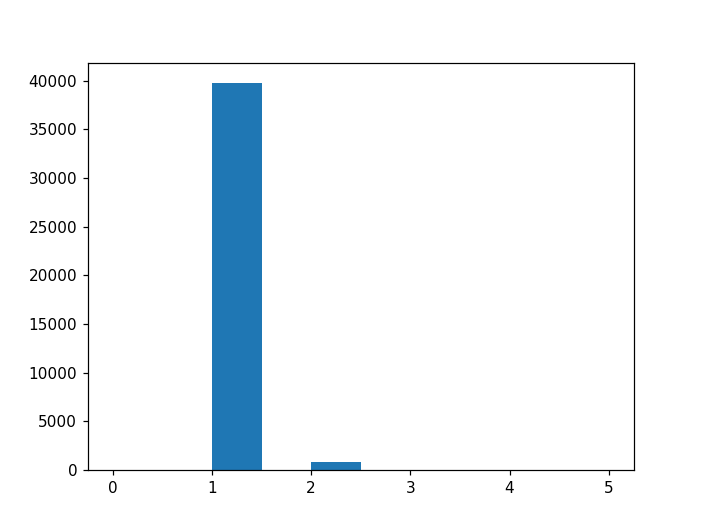

<IPython.core.display.Javascript object>


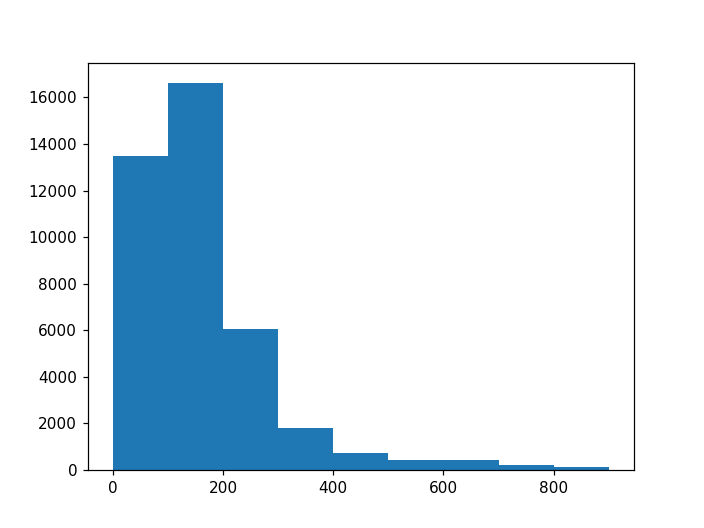

(array([ 13483.,  16633.,   6074.,   1809.,    712.,    422.,    417.,
           225.,    135.]),
 array([  0, 100, 200, 300, 400, 500, 600, 700, 800, 900]),
 <a list of 9 Patch objects>)

In [103]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.figure()
plt.hist(np.concatenate(hard_counts,axis=0))
plt.figure()
plt.hist(np.concatenate(soft_counts,axis=0), bins=range(0,1000,100))

## 7. Post Processing after blast

In [113]:
def Screening_Probes_by_Blast(library_folder, probe_per_region, blast_subfolder='blast', 
                              probe_subfolder='final_probes', probe_filename='filtered_probes.fasta',
                              soft_count_th=30, 
                              smallest_region_ratio=0.75,
                              save=True, save_filename='blast_centered_probes.fasta',
                              verbose=True,):
    '''Read blast results in blast folder and probe in filtered__probes, keep'''
    # folders
    _blast_folder = library_folder + os.sep + blast_subfolder
    _probe_folder = library_folder + os.sep + probe_subfolder
    # load probes
    _probes = [];
    with open(_probe_folder+os.sep+probe_filename,'r') as _handle:
        for _record in SeqIO.parse(_handle, "fasta"):
            _probes.append(_record)   
    if verbose:
        print "- Number of probes loaded:", len(_probes)
    # parse loaded probes by region
    _pb_dic = split_library_by_region(_probes)    
    if verbose:
        print "- Number of regions in this library:", len(_pb_dic);
    # dictionary to store whether keep this probe
    _keep_dic = {} # whether keep because of blast only
    _kept_pb_dic = {}
    _hard_count_list = []
    _soft_count_list = []
    # loop through all regions 
    for _reg, _pbs in sorted(_pb_dic.items()):
        if verbose:
            print "-- checking probes in region:", _reg
        _keep_dic[_reg] = np.ones(len(_pbs), dtype=np.bool) # initialize with True
        # parse blast result of this region
        blast_records = NCBIXML.parse(open(_blast_folder+os.sep+'blast_reg_'+str(_reg)+'.xml', 'r'))
        # loop through each probe in this region
        _hard_cts, _soft_cts = [],[]
        for _pbid, blast_record in enumerate(blast_records):
            _hc, _sc = acquire_blast_counts(blast_record, hard_thres=42, soft_thres=20, verbose=verbose_parse);
            _hard_cts.append(_hc)
            _soft_cts.append(_sc)
            if _hc > 2 or _hc < 1: # if this probe has no hit, or more than 2 hits, remove
                _keep_dic[_reg][_pbid] = False
                continue
            if _sc > soft_count_th: # if this probe has too many soft counts (20mer hits)
                _keep_dic[_reg][_pbid] = False
                continue
        # after looped through this region, check the hard counts
        _hard_cts = np.array(_hard_cts);
        _soft_cts = np.array(_soft_cts);
        _hard_count_list.append(_hard_cts)
        _soft_count_list.append(_soft_cts)
        if verbose:
            print "--- number of probes:", len(_pbs), ", kept by blast:", sum(_keep_dic[_reg]), ", if remove dups:", sum(_keep_dic[_reg] * (_hard_cts==1)) 
        # check duplicated probes
        if sum(_keep_dic[_reg] * (_hard_cts==1)) / float(sum(_keep_dic[_reg])) >= smallest_region_ratio and sum(_keep_dic[_reg]) >= smallest_region_ratio*probe_per_region:
            print '--- remove duplicated probes'
            _keep_dic[_reg] = _keep_dic[_reg] * (_hard_cts==1)
        
        # generate list of kept probes
        _kept_pbs = [_pb for _pb,_k in zip(_pbs, _keep_dic[_reg]) if _k]
                
        # keep the center of this region
        if sum(_keep_dic[_reg]) > probe_per_region:
            if verbose:
                print "--- keep centered probes"
            _start, _end = _pbs[0].id.split(':')[1].split('_')[0].split('-')
            _start, _end = int(_start), int(_end)
            _reg_len = np.abs(_end - _start)
            _kept_center_pbs = []
            for _pb in sorted(_kept_pbs, key=lambda p: np.abs(int(p.id.split('pb_')[1].split('_')[0])-_reg_len/2) ):
                _kept_center_pbs.append(_pb)
                if len(_kept_center_pbs) >= probe_per_region:
                    break
            _kept_pb_dic[_reg] = sorted(_kept_center_pbs ,key=lambda p:int(p.id.split('pb_')[1].split('_')[0]))
        else:
            _kept_pb_dic[_reg] = sorted(_kept_pbs ,key=lambda p:int(p.id.split('pb_')[1].split('_')[0]))
        if verbose:
            print '-- number of probes kept for this region:', len(_kept_pb_dic[_reg])
    
    
    # SUMMARIZE
    _kept_probe_list = []
    if verbose:
        print "- summarize";
    for _reg, _pbs in sorted(_kept_pb_dic.items()):
        if verbose:
            print "-- region:", _reg, ", number of probes:",len(_pbs);
        _kept_probe_list += _pbs 
        
    print "- Number of probes kept:", len(_kept_probe_list)
    
    if save:
        if verbose:
            print "- Saving to file:", _probe_folder + os.sep + save_filename
        with open(_probe_folder + os.sep + save_filename, 'w') as _output_handle:
            SeqIO.write(_kept_probe_list, _output_handle, 'fasta'); 
            
            
    return _kept_probe_list, _keep_dic, _hard_count_list, _soft_count_list

In [114]:
kept_pbs, blast_keep_dic, hard_count_list, soft_count_list = Screening_Probes_by_Blast(library_folder, 250)

- Number of probes loaded: 40593
- Number of regions in this library: 126
-- checking probes in region: 0
--- number of probes: 190 , kept by blast: 187 , if remove dups: 155
-- number of probes kept for this region: 187
-- checking probes in region: 1
--- number of probes: 150 , kept by blast: 143 , if remove dups: 134
-- number of probes kept for this region: 143
-- checking probes in region: 2
--- number of probes: 238 , kept by blast: 222 , if remove dups: 221
--- remove duplicated probes
-- number of probes kept for this region: 221
-- checking probes in region: 3
--- number of probes: 337 , kept by blast: 326 , if remove dups: 326
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 250
-- checking probes in region: 4
--- number of probes: 363 , kept by blast: 361 , if remove dups: 361
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 250
-- checking probes in region: 5
--- number of probes: 

--- number of probes: 298 , kept by blast: 282 , if remove dups: 282
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 250
-- checking probes in region: 44
--- number of probes: 337 , kept by blast: 324 , if remove dups: 324
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 250
-- checking probes in region: 45
--- number of probes: 312 , kept by blast: 297 , if remove dups: 296
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 250
-- checking probes in region: 46
--- number of probes: 398 , kept by blast: 386 , if remove dups: 386
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 250
-- checking probes in region: 47
--- number of probes: 274 , kept by blast: 214 , if remove dups: 214
--- remove duplicated probes
-- number of probes kept for this region: 214
-- checking probes in region: 48
--- number of p

--- number of probes: 398 , kept by blast: 386 , if remove dups: 385
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 250
-- checking probes in region: 86
--- number of probes: 370 , kept by blast: 356 , if remove dups: 356
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 250
-- checking probes in region: 87
--- number of probes: 388 , kept by blast: 370 , if remove dups: 370
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 250
-- checking probes in region: 88
--- number of probes: 382 , kept by blast: 377 , if remove dups: 377
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 250
-- checking probes in region: 89
--- number of probes: 370 , kept by blast: 356 , if remove dups: 356
--- remove duplicated probes
--- keep centered probes
-- number of probes kept for this region: 250
-- checking probes in r

In [3]:
library_folder = r'/n/boslfs/LABS/zhuang_lab/User/pzheng/Libraries/CTP-04/chr21_7by21'
probe_subfolder = 'final_probes'
blast_probe_filename = 'blast_centered_probes.fasta'

kept_pbs = [];
with open(library_folder+os.sep+probe_subfolder+os.sep+blast_probe_filename,'r') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        kept_pbs.append(record)
print len(kept_pbs)

30036


In [6]:
kept_blasted_pbs, kept_blasted_size_dic = Check_Probes(kept_pbs, library_folder, [2,9], 
                                           save=True, save_filename='filtered_blast_centered_probes.fasta')

- 0. Loading primers and readouts
Primers loaded: forward: W1A03_primer_2, reverse: W1A10_primer_9
-- loading readout seqs from colors: 3
-- loading readout seqs from colors: 3
-- Checking primer usage, total probes: 30036

- 1.Passing primer usage check? - True

- 2.Passing region size check? - True
0 : 187
1 : 143
2 : 221
3 : 250
4 : 250
5 : 250
6 : 250
7 : 250
8 : 250
9 : 202
10 : 190
11 : 250
12 : 250
13 : 250
14 : 250
15 : 250
16 : 219
17 : 250
18 : 250
19 : 207
20 : 250
21 : 250
22 : 242
23 : 250
24 : 135
25 : 166
26 : 250
27 : 250
28 : 250
29 : 250
30 : 250
31 : 250
32 : 249
33 : 181
34 : 250
35 : 250
36 : 250
37 : 250
38 : 250
39 : 250
40 : 155
41 : 250
42 : 250
43 : 250
44 : 250
45 : 250
46 : 250
47 : 214
48 : 250
49 : 231
50 : 250
51 : 250
52 : 250
53 : 227
54 : 250
55 : 250
56 : 250
57 : 250
58 : 233
59 : 250
60 : 250
61 : 250
62 : 194
63 : 250
64 : 250
65 : 250
66 : 250
67 : 250
68 : 250
69 : 250
70 : 250
71 : 250
72 : 250
73 : 250
74 : 250
75 : 250
76 : 211
77 : 212
78 : 2


- 5.Calculating barcode to color dictionary.
NDB_329 : [1]
NDB_332 : [1]
NDB_335 : [1]
NDB_341 : [1]
NDB_344 : [1]
NDB_347 : [1]
NDB_350 : [1]
NDB_353 : [1]
NDB_356 : [1]
NDB_359 : [1]
NDB_362 : [1]
NDB_365 : [1]
NDB_366 : [2]
NDB_368 : [1]
NDB_369 : [2]
NDB_371 : [1]
NDB_372 : [2]
NDB_373 : [0]
NDB_374 : [1]
NDB_375 : [2]
NDB_376 : [0]
NDB_377 : [1]
NDB_378 : [2]
NDB_379 : [0]
NDB_380 : [1]
NDB_381 : [2]
NDB_383 : [1]
NDB_384 : [2]
NDB_385 : [0]
NDB_386 : [1]
NDB_387 : [2]
NDB_388 : [0]
NDB_389 : [1]
NDB_390 : [2]
NDB_391 : [0]
NDB_392 : [1]
NDB_393 : [2]
NDB_395 : [1]
NDB_396 : [2]
NDB_397 : [0]
NDB_398 : [1]
NDB_400 : [0]
NDB_401 : [1]
NDB_402 : [2]
NDB_403 : [0]
NDB_404 : [1]
NDB_405 : [2]
NDB_406 : [0]
NDB_407 : [1]
NDB_409 : [0]
NDB_410 : [1]
NDB_413 : [1]
NDB_414 : [2]
NDB_416 : [1]
NDB_417 : [2]
NDB_418 : [0]
NDB_419 : [1]
NDB_420 : [2]
NDB_421 : [0]
NDB_422 : [1]
NDB_423 : [2]
NDB_425 : [1]
NDB_426 : [2]
NDB_427 : [0]
NDB_428 : [1]
NDB_429 : [2]
NDB_431 : [1]
NDB_432 : [2]
ND